**Background**

A manager at a bank was bothered by
more and more client abandoning their credit card service.

**Objective**

They would appreciate it if someone
can figure out the customer profile so that they can
know which client are going to leave so that they can
can proactively go to the customer to
provide better service and change the decision of
client in the opposite direction.

**Connect Google Colaboratory to Google Drive**

In [436]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import Library**

In [437]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest #feature selection
from sklearn.feature_selection import chi2
from sklearn.utils import resample #re-sampling
from sklearn.model_selection import train_test_split #data splitting
from sklearn.preprocessing import StandardScaler #normalize features

from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.naive_bayes import GaussianNB #gaussian naive bayes
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier #decision tree
from sklearn.ensemble import RandomForestClassifier #random forest
from sklearn.ensemble import GradientBoostingClassifier #Gradient Boosting Classifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score #roc score

**Import and Inspect Dataset**

In [438]:
#import dataset
df = pd.read_csv('/content/drive/MyDrive/data_master_customer.csv', delimiter=';')

#display dataset form
print('This dataset has %d rows dan %d columns.\n' % df.shape)

#display top 5 rows of the dataset
df.head()

This dataset has 10127 rows dan 23 columns.



,CLIENTNUM,idstatus,status,Customer_Age,Gender,Dependent_count,Educationid,Education_Level,Maritalid,Marital_Status,Income_Category,card_categoryid,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Trans_Amt,Total_Trans_Ct,Avg_Utilization_Ratio
0,768805383,1,Existing Customer,45,Male,3,1,High School,1,Married,$60K - $80K,1,Blue,39,5,1,3,12691,777,11914,1144,42,0.061
1,818770008,1,Existing Customer,49,Female,5,2,Graduate,2,Single,Less than $40K,1,Blue,44,6,1,2,8256,864,7392,1291,33,0.105
2,713982108,1,Existing Customer,51,Male,3,2,Graduate,1,Married,$80K - $120K,1,Blue,36,4,1,0,3418,0,3418,1887,20,0.000
3,769911858,1,Existing Customer,40,Female,4,1,High School,3,Unknown,Less than $40K,1,Blue,34,3,4,1,3313,2517,796,1171,20,0.760
4,709106358,1,Existing Customer,40,Male,3,3,Uneducated,1,Married,$60K - $80K,1,Blue,21,5,1,0,4716,0,4716,816,28,0.000


In [439]:
df.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   idstatus                  10127 non-null  int64  
 2   status                    10127 non-null  object 
 3   Customer_Age              10127 non-null  int64  
 4   Gender                    10127 non-null  object 
 5   Dependent_count           10127 non-null  int64  
 6   Educationid               10127 non-null  int64  
 7   Education_Level           10127 non-null  object 
 8   Maritalid                 10127 non-null  int64  
 9   Marital_Status            10127 non-null  object 
 10  Income_Category           10127 non-null  object 
 11  card_categoryid           10127 non-null  int64  
 12  Card_Category             10127 non-null  object 
 13  Months_on_book            10127 non-null  int64  
 14  Total_

**Exploratory Data Analysis**

**Distribution of Customer Status**

In [440]:
cust_status = df.groupby('status').agg(cnt_client=('CLIENTNUM','count')).reset_index()
cust_status.style.background_gradient(cmap='gnuplot2_r')

,status,cnt_client
0,Attrited Customer,1627
1,Existing Customer,8500


In [441]:
cust_norm = df['status'].value_counts(normalize=True).mul(100).round(2).reset_index()
cust_norm.columns = ['status','distribution']
cust_norm.style.background_gradient(cmap='gnuplot2_r')

,status,distribution
0,Existing Customer,83.930000
1,Attrited Customer,16.070000


[Text(0, 0, '1627 (16.07%)'), Text(0, 0, '8500 (83.93%)')]

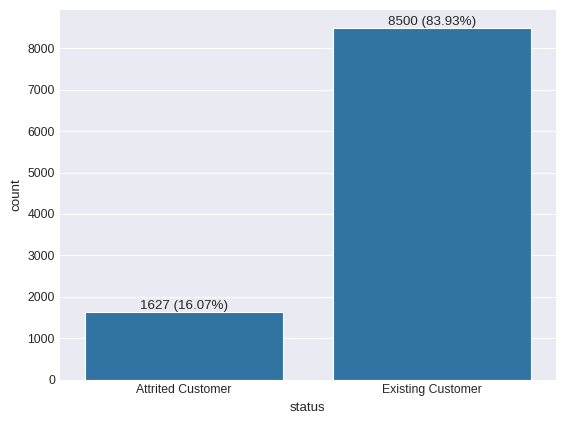

In [442]:
ax = sns.countplot(x=df['status'],
                   order=df['status'].value_counts(ascending=True).index);

abs_values = df['status'].value_counts(ascending=True)
rel_values = df['status'].value_counts(ascending=True, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.2f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

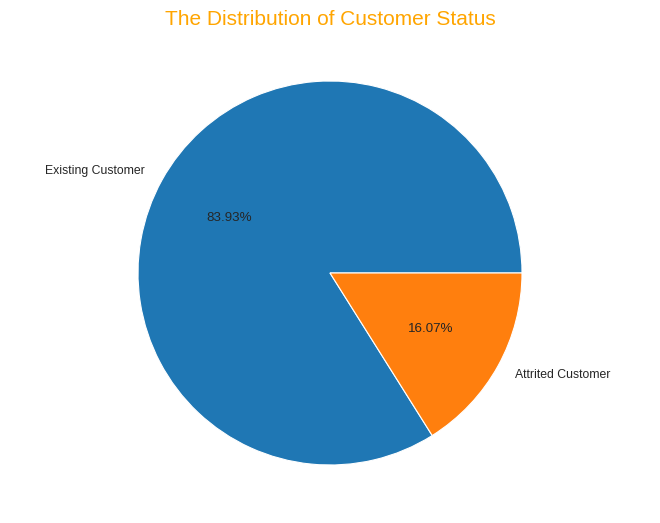

In [443]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
labels = ['Existing Customer','Attrited Customer']
churn = df.status.value_counts()
ax.pie(churn, labels=labels, autopct= '%.2f%%')
plt.title(label = 'The Distribution of Customer Status',
          size = 15,
          color = 'orange')
plt.show()

From the distribution of customer status, we know that :
*   **There are 8500 Existing Customer that still use credit card service and 1627 Attrited Customer**
*   **There are 83.93% Existing Customer that still use credit card service and 16.07% did not use credit card service anymore (Attrited Customer)**

Notes: Attrited client are the group of client that has been lost through time for any reason. The process of losing a client is referred to as customer attrition, also known as customer churn.



## **Data Visualization of Customer Status**

Distribution of Customer Status by:
*   Gender
*   Marital Status
*   Education Level
*   Income Type
*   Card Category

<Axes: title={'center': 'Clients Status By Income Type'}, xlabel='Income_Category', ylabel='count'>

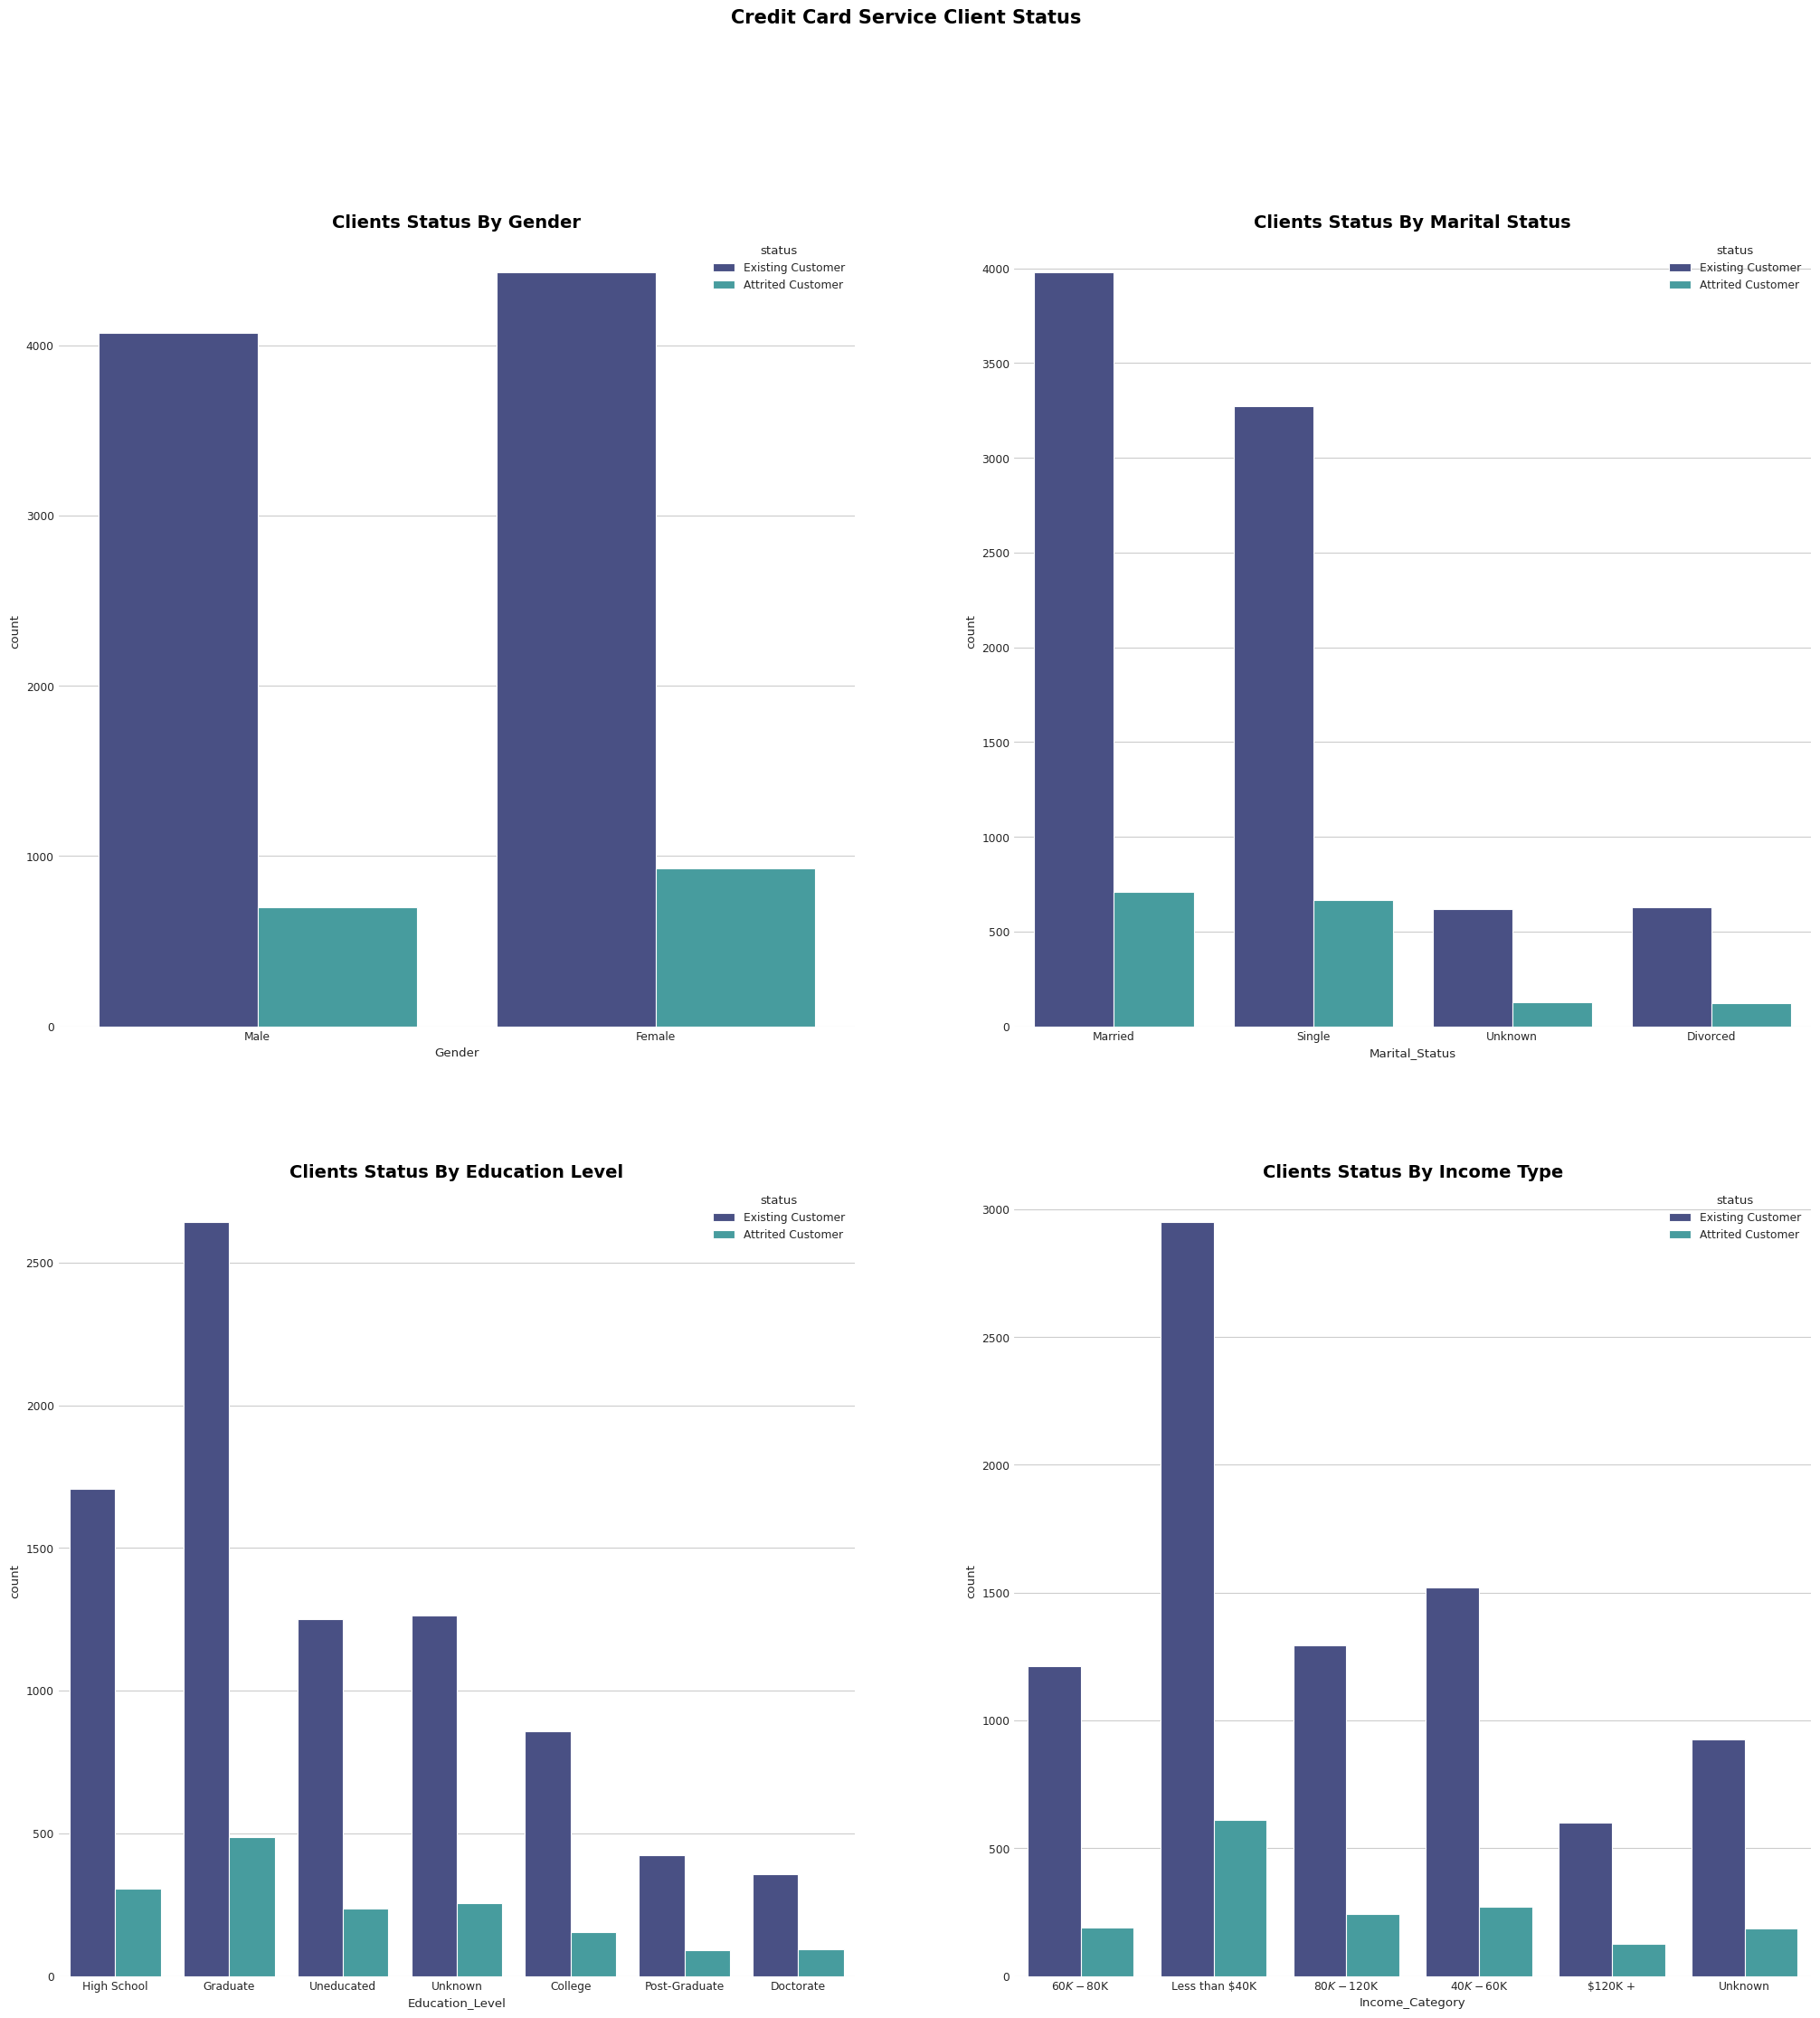

In [444]:
#Data Visualization of Customer Status
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2 , figsize=(25,25))
sns.set_context('paper', font_scale=1)

#Give Title
fig.suptitle('Credit Card Service Client Status',color = 'black', fontweight= 'bold',fontsize = 15)

ax[0][0].set_title('Clients Status By Gender', fontweight='bold', fontsize=14, color='black')
sns.countplot(x='Gender', data = df, hue = 'status', palette = 'mako', ax=ax[0][0])

ax[0][1].set_title('Clients Status By Marital Status', fontweight='bold', fontsize=14, color='black')
sns.countplot(x='Marital_Status', data = df, hue = 'status', palette = 'mako', ax=ax[0][1])

ax[1][0].set_title('Clients Status By Education Level', fontweight='bold', fontsize=14, color='black')
sns.countplot(x='Education_Level', data = df, hue = 'status', palette = 'mako', ax=ax[1][0])

ax[1][1].set_title('Clients Status By Income Type', fontweight='bold', fontsize=14, color='black')
sns.countplot(x='Income_Category', data = df, hue = 'status', palette = 'mako', ax=ax[1][1])

Text(0.5, 0, '\nCard Category')

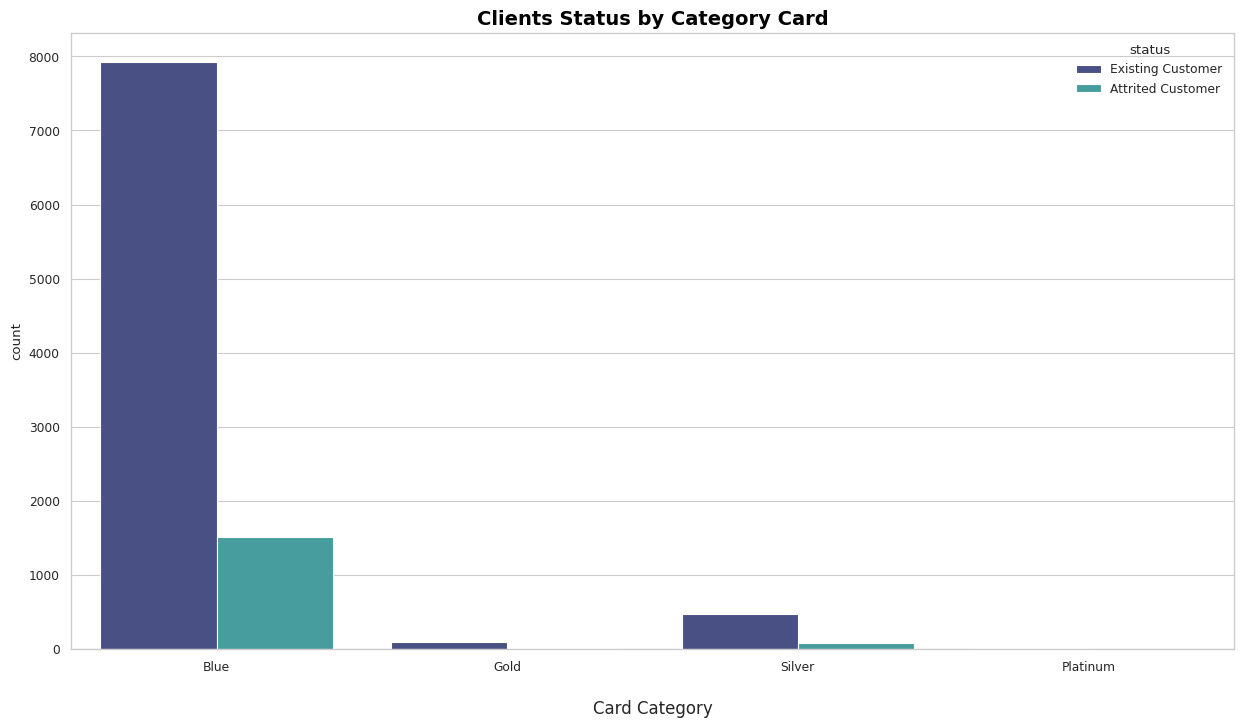

In [445]:
#Data Visualization of Customer Status
plt.figure(figsize=(15,8))
fig = sns.countplot(x='Card_Category', data = df, hue = 'status', palette = 'mako')
plt.title('Clients Status by Category Card', fontweight='bold', fontsize=14, color='black')
plt.xlabel('\nCard Category', fontsize=12)

In [446]:
 #Client Status by Gender
df_gender = df.groupby(by=['Gender','status']).agg(cnt_client=('CLIENTNUM','count')).sort_values(by=['Gender','status'],ascending=True).reset_index()
df_gender['percentage'] = 100 * df_gender['cnt_client'] / df_gender.groupby('Gender')['cnt_client'].transform('sum')
df_gender.style.background_gradient(cmap='BuGn')

,Gender,status,cnt_client,percentage
0,Female,Attrited Customer,930,17.357223
1,Female,Existing Customer,4428,82.642777
2,Male,Attrited Customer,697,14.615223
3,Male,Existing Customer,4072,85.384777


In [447]:
 #Client Status by Marital Status
df_marital = df.groupby(by=['Marital_Status','status']).agg(cnt_client=('CLIENTNUM','count')).sort_values(by=['Marital_Status','status'],ascending=True).reset_index()
df_marital['percentage'] = 100 * df_marital['cnt_client'] / df_marital.groupby('Marital_Status')['cnt_client'].transform('sum')
df_marital.style.background_gradient(cmap='BuGn')

,Marital_Status,status,cnt_client,percentage
0,Divorced,Attrited Customer,121,16.176471
1,Divorced,Existing Customer,627,83.823529
2,Married,Attrited Customer,709,15.126947
3,Married,Existing Customer,3978,84.873053
4,Single,Attrited Customer,668,16.941415
5,Single,Existing Customer,3275,83.058585
6,Unknown,Attrited Customer,129,17.222964
7,Unknown,Existing Customer,620,82.777036


In [448]:
 #Client Status by Education Level
df_education = df.groupby(by=['Education_Level','status']).agg(cnt_client=('CLIENTNUM','count')).sort_values(by=['Education_Level','status'],ascending=True).reset_index()
df_education['percentage'] = 100 * df_education['cnt_client'] / df_education.groupby('Education_Level')['cnt_client'].transform('sum')
df_education.style.background_gradient(cmap='BuGn')

,Education_Level,status,cnt_client,percentage
0,College,Attrited Customer,154,15.202369
1,College,Existing Customer,859,84.797631
2,Doctorate,Attrited Customer,95,21.064302
3,Doctorate,Existing Customer,356,78.935698
4,Graduate,Attrited Customer,487,15.569054
5,Graduate,Existing Customer,2641,84.430946
6,High School,Attrited Customer,306,15.201192
7,High School,Existing Customer,1707,84.798808
8,Post-Graduate,Attrited Customer,92,17.829457
9,Post-Graduate,Existing Customer,424,82.170543


In [449]:
#Client Status by Income Category (Type)
df_income = df.groupby(by=['Income_Category','status']).agg(cnt_client=('CLIENTNUM','count')).sort_values(by=['Income_Category','status'],ascending=True).reset_index()
df_income['percentage'] = 100 * df_income['cnt_client'] / df_income.groupby('Income_Category')['cnt_client'].transform('sum')
df_income.style.background_gradient(cmap='BuGn')

,Income_Category,status,cnt_client,percentage
0,$120K +,Attrited Customer,126,17.331499
1,$120K +,Existing Customer,601,82.668501
2,$40K - $60K,Attrited Customer,271,15.139665
3,$40K - $60K,Existing Customer,1519,84.860335
4,$60K - $80K,Attrited Customer,189,13.480742
5,$60K - $80K,Existing Customer,1213,86.519258
6,$80K - $120K,Attrited Customer,242,15.765472
7,$80K - $120K,Existing Customer,1293,84.234528
8,Less than $40K,Attrited Customer,612,17.186184
9,Less than $40K,Existing Customer,2949,82.813816


In [450]:
#Client Status by Card Category
df_card = df.groupby(by=['Card_Category','status']).agg(cnt_client=('CLIENTNUM','count')).sort_values(by=['Card_Category','status'],ascending=True).reset_index()
df_card['percentage'] = 100 * df_card['cnt_client'] / df_card.groupby('Card_Category')['cnt_client'].transform('sum')
df_card.style.background_gradient(cmap='BuGn')

,Card_Category,status,cnt_client,percentage
0,Blue,Attrited Customer,1519,16.097923
1,Blue,Existing Customer,7917,83.902077
2,Gold,Attrited Customer,21,18.103448
3,Gold,Existing Customer,95,81.896552
4,Platinum,Attrited Customer,5,25.000000
5,Platinum,Existing Customer,15,75.000000
6,Silver,Attrited Customer,82,14.774775
7,Silver,Existing Customer,473,85.225225


**Bivariate Analysis : Numerical Features vs Target**



Credit Limit vs Target

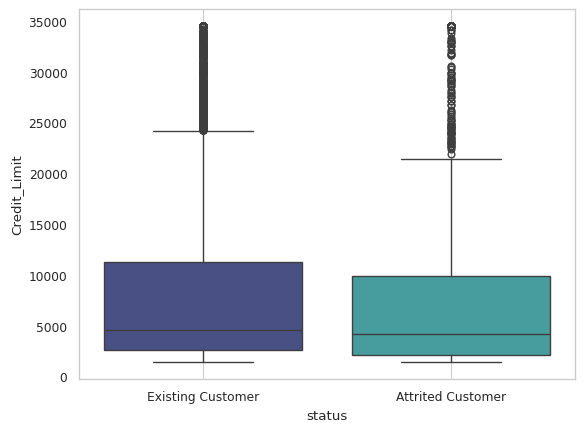

In [451]:
sns.boxplot(x='status', y='Credit_Limit', data=df, palette = 'mako')
plt.grid()
plt.show()

In [452]:
df_cclimit = df.groupby('status').agg(credit_limit_med=('Credit_Limit','median')).reset_index()
df_cclimit.style.background_gradient(cmap='mako')

,status,credit_limit_med
0,Attrited Customer,4178.000000
1,Existing Customer,4643.500000


Inactive Months vs Target

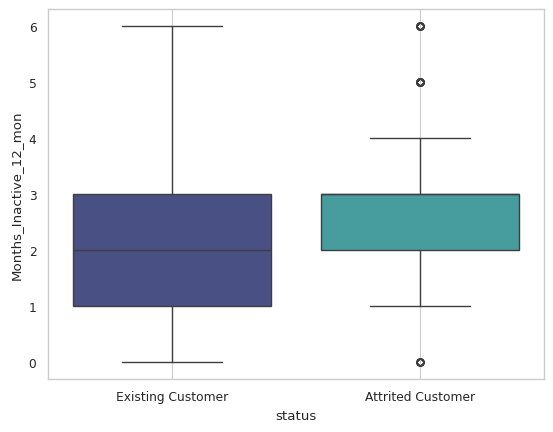

In [453]:
sns.boxplot(x='status', y='Months_Inactive_12_mon', data=df, palette = 'mako')
plt.grid()
plt.show()

In [454]:
df_inactive= df.groupby('status').agg(inactive_med=('Months_Inactive_12_mon','median')).reset_index()
df_inactive.style.background_gradient(cmap='mako')

,status,inactive_med
0,Attrited Customer,3.000000
1,Existing Customer,2.000000


Client Age

In [455]:
attrited_age = df[df['status']=='Attrited Customer']['Customer_Age']
existing_age = df[df['status']=='Existing Customer']['Customer_Age']

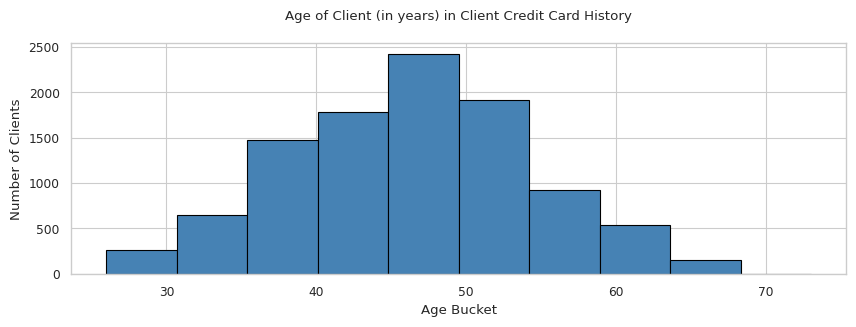

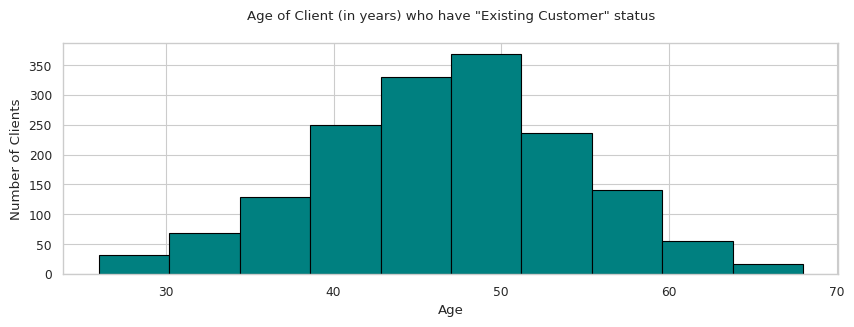

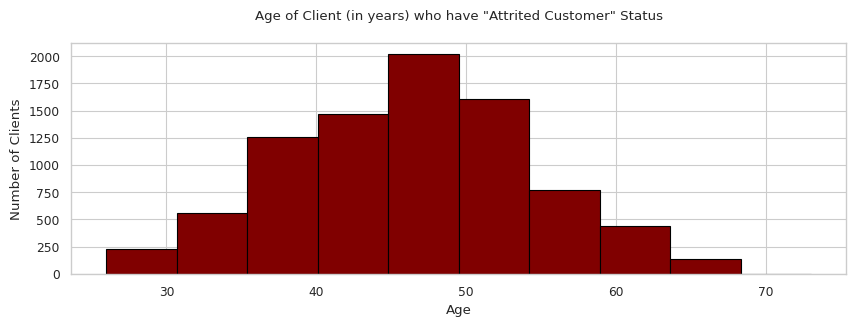

In [456]:
plt.figure(figsize=(10,3))
plt.hist(df['Customer_Age'], bins=10, edgecolor='black', color='steelblue')
plt.title('Age of Client (in years) in Client Credit Card History\n')
plt.xlabel('Age Bucket')
plt.ylabel('Number of Clients')
plt.show()

plt.figure(figsize=(10,3))
plt.hist(attrited_age, bins=10, edgecolor='black', color='teal')
plt.title('Age of Client (in years) who have "Existing Customer" status\n')
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.show()

plt.figure(figsize=(10,3))
plt.hist(existing_age, bins=10, edgecolor='black', color='maroon')
plt.title('Age of Client (in years) who have "Attrited Customer" Status\n')
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.show()

**Multivariate Analysis**

**Grouped By Education Level**

1. Education Level, Dependent Count, Marital Status, Customer Status

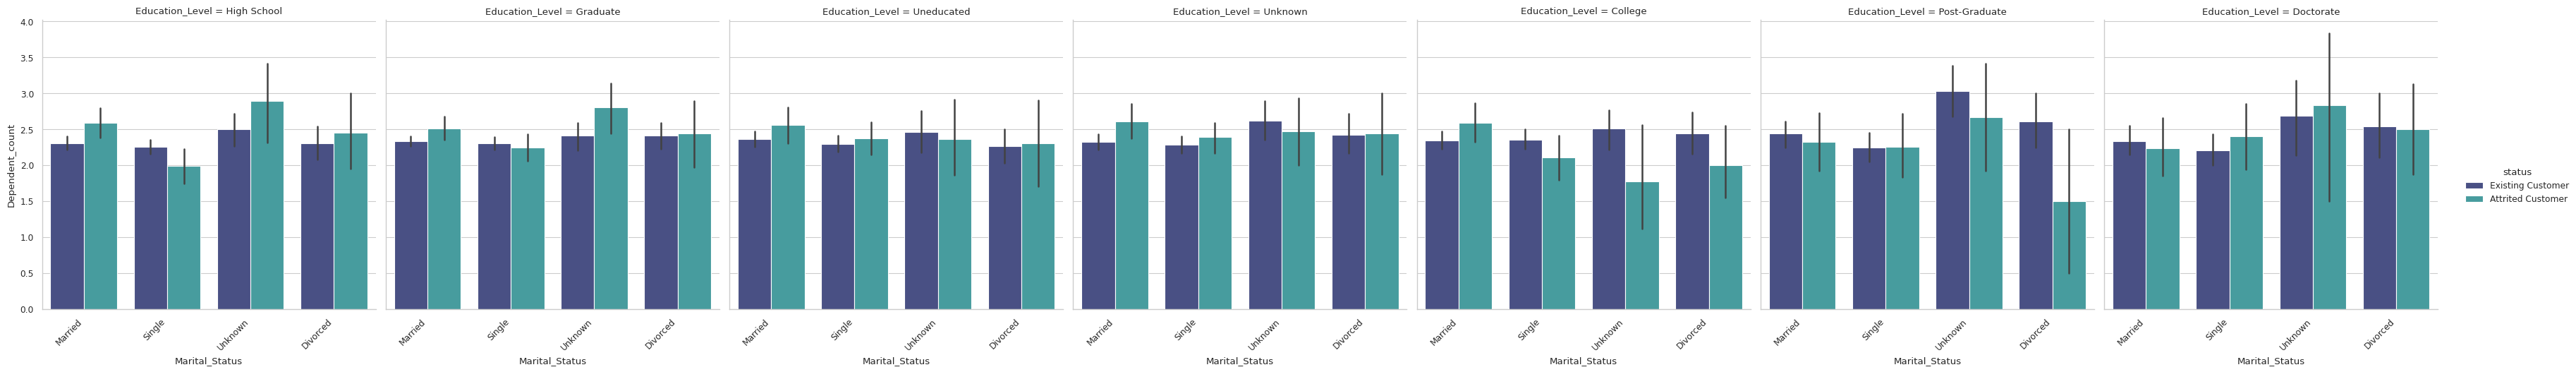

In [457]:
fig = sns.catplot(x = 'Marital_Status',
            y = 'Dependent_count',
            hue = 'status',
            col = 'Education_Level',
            kind = 'bar', palette = 'mako',
            data = df)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

In [458]:
df_edu1 = df.groupby(by=['Education_Level','Marital_Status','status']).agg(cnt_client=('Dependent_count','mean')).sort_values(by=['Education_Level','Marital_Status','status','cnt_client'],ascending=True).reset_index()
df_edu1.style.background_gradient(cmap='BuGn')

,Education_Level,Marital_Status,status,cnt_client
0,College,Divorced,Attrited Customer,2.000000
1,College,Divorced,Existing Customer,2.440000
2,College,Married,Attrited Customer,2.591549
3,College,Married,Existing Customer,2.345960
4,College,Single,Attrited Customer,2.111111
5,College,Single,Existing Customer,2.352941
6,College,Unknown,Attrited Customer,1.777778
7,College,Unknown,Existing Customer,2.507692
8,Doctorate,Divorced,Attrited Customer,2.500000
9,Doctorate,Divorced,Existing Customer,2.535714


2. Education Level, Average Utilization Ratio, Marital Status, Customer Status

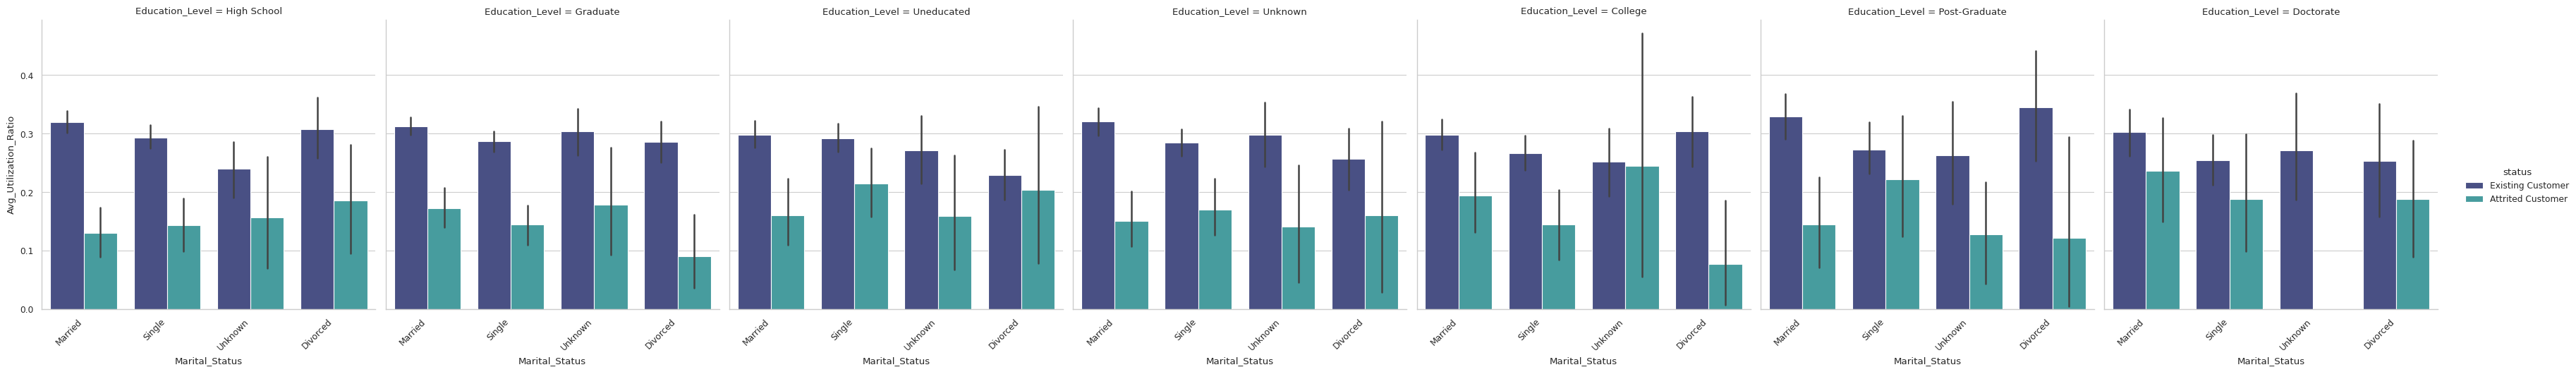

In [459]:
fig = sns.catplot(x = 'Marital_Status',
            y = 'Avg_Utilization_Ratio',
            hue = 'status',
            col = 'Education_Level',
            kind = 'bar', palette = 'mako',
            data = df)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

In [460]:
df_edu2 = df.groupby(by=['Education_Level','Marital_Status','status']).agg(avg_utilization_ratio=('Avg_Utilization_Ratio','mean')).sort_values(by=['Education_Level','Marital_Status','status','avg_utilization_ratio'],ascending=True).reset_index()
df_edu2.style.background_gradient(cmap='BuGn')

,Education_Level,Marital_Status,status,avg_utilization_ratio
0,College,Divorced,Attrited Customer,0.076636
1,College,Divorced,Existing Customer,0.303293
2,College,Married,Attrited Customer,0.194000
3,College,Married,Existing Customer,0.297742
4,College,Single,Attrited Customer,0.144016
5,College,Single,Existing Customer,0.266189
6,College,Unknown,Attrited Customer,0.244111
7,College,Unknown,Existing Customer,0.251231
8,Doctorate,Divorced,Attrited Customer,0.187375
9,Doctorate,Divorced,Existing Customer,0.252786


3. Education Level, Credit Limit, Marital Status, Customer Status

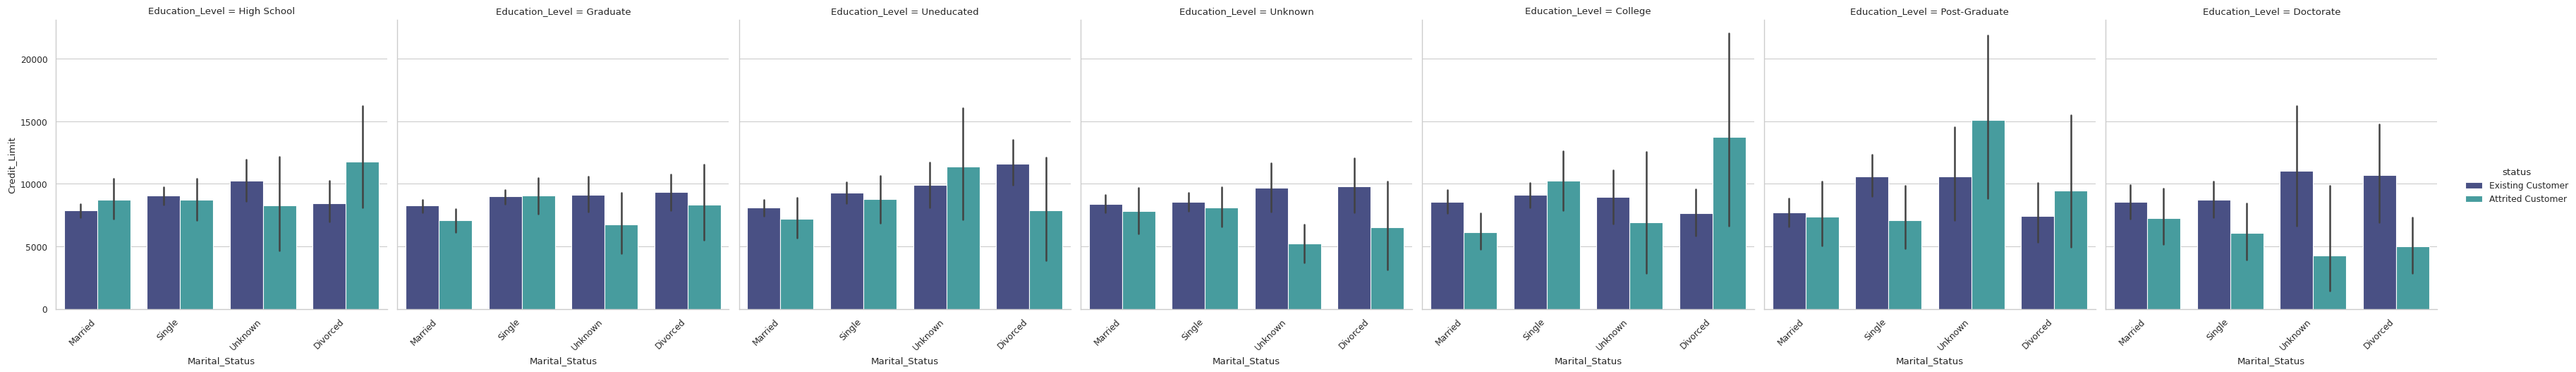

In [461]:
fig = sns.catplot(x = 'Marital_Status',
            y = 'Credit_Limit',
            hue = 'status',
            col = 'Education_Level',
            kind = 'bar', palette = 'mako',
            data = df)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

In [462]:
df_edu3 = df.groupby(by=['Education_Level','Marital_Status','status']).agg(avg_credit_limit=('Credit_Limit','mean')).sort_values(by=['Education_Level','Marital_Status','status','avg_credit_limit'],ascending=True).reset_index()
df_edu3.style.background_gradient(cmap='BuGn')

,Education_Level,Marital_Status,status,avg_credit_limit
0,College,Divorced,Attrited Customer,13778.454545
1,College,Divorced,Existing Customer,7645.653333
2,College,Married,Attrited Customer,6155.591549
3,College,Married,Existing Customer,8576.156566
4,College,Single,Attrited Customer,10228.015873
5,College,Single,Existing Customer,9138.452012
6,College,Unknown,Attrited Customer,6941.333333
7,College,Unknown,Existing Customer,8933.323077
8,Doctorate,Divorced,Attrited Customer,4996.000000
9,Doctorate,Divorced,Existing Customer,10678.107143


4. Education Level, Average Open To Buy, Marital Status, Customer Status

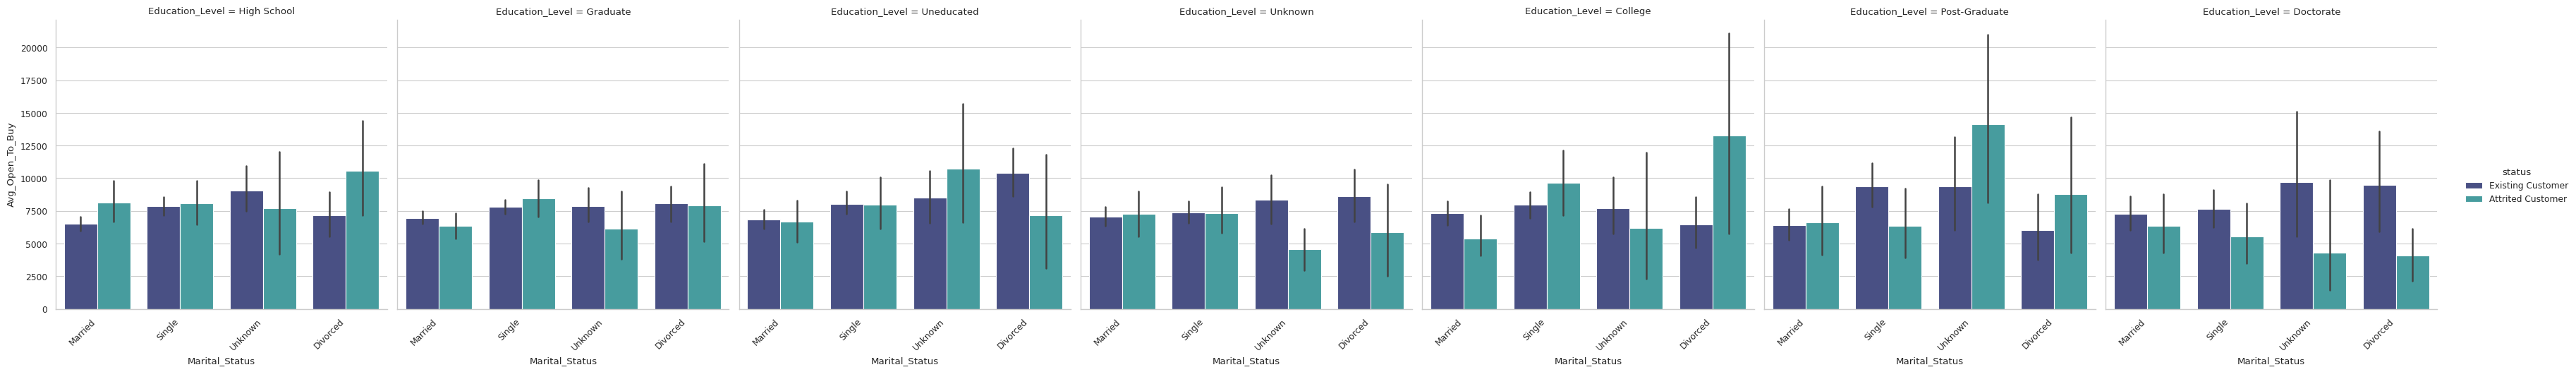

In [463]:
fig = sns.catplot(x = 'Marital_Status',
            y = 'Avg_Open_To_Buy',
            hue = 'status',
            col = 'Education_Level',
            kind = 'bar', palette = 'mako',
            data = df)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

In [464]:
df_edu5 = df.groupby(by=['Education_Level','Marital_Status','status']).agg(avg_opentobuy=('Avg_Open_To_Buy','mean')).sort_values(by=['Education_Level','Marital_Status','status','avg_opentobuy'],ascending=True).reset_index()
df_edu5.style.background_gradient(cmap='BuGn')

,Education_Level,Marital_Status,status,avg_opentobuy
0,College,Divorced,Attrited Customer,13286.727273
1,College,Divorced,Existing Customer,6432.226667
2,College,Married,Attrited Customer,5379.690141
3,College,Married,Existing Customer,7335.545455
4,College,Single,Attrited Customer,9632.317460
5,College,Single,Existing Customer,7947.557276
6,College,Unknown,Attrited Customer,6200.444444
7,College,Unknown,Existing Customer,7719.384615
8,Doctorate,Divorced,Attrited Customer,4056.750000
9,Doctorate,Divorced,Existing Customer,9502.214286


5. Education Level, Total Transaction Amount, Marital Status, Customer Status

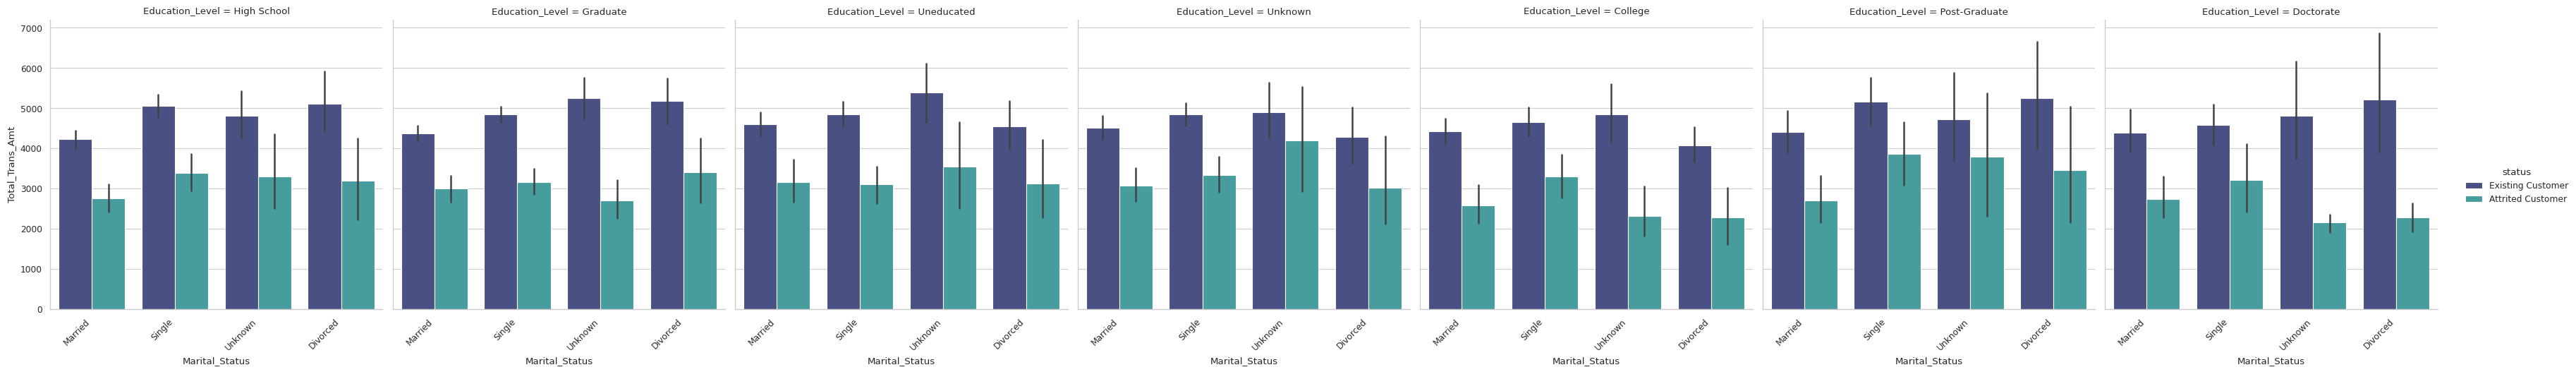

In [465]:
fig = sns.catplot(x = 'Marital_Status',
            y = 'Total_Trans_Amt',
            hue = 'status',
            col = 'Education_Level',
            kind = 'bar', palette = 'mako',
            data = df)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

In [466]:
df_edu6 = df.groupby(by=['Education_Level','Marital_Status','status']).agg(avg_trans_amt=('Total_Trans_Amt','mean')).sort_values(by=['Education_Level','Marital_Status','status','avg_trans_amt'],ascending=True).reset_index()
df_edu6.style.background_gradient(cmap='BuGn')

,Education_Level,Marital_Status,status,avg_trans_amt
0,College,Divorced,Attrited Customer,2274.454545
1,College,Divorced,Existing Customer,4075.293333
2,College,Married,Attrited Customer,2582.042254
3,College,Married,Existing Customer,4427.949495
4,College,Single,Attrited Customer,3300.365079
5,College,Single,Existing Customer,4646.356037
6,College,Unknown,Attrited Customer,2306.222222
7,College,Unknown,Existing Customer,4834.169231
8,Doctorate,Divorced,Attrited Customer,2276.375000
9,Doctorate,Divorced,Existing Customer,5213.035714


**Grouped By Income Category**

1. Income Category, Dependent Count, Marital Status, Customer Status

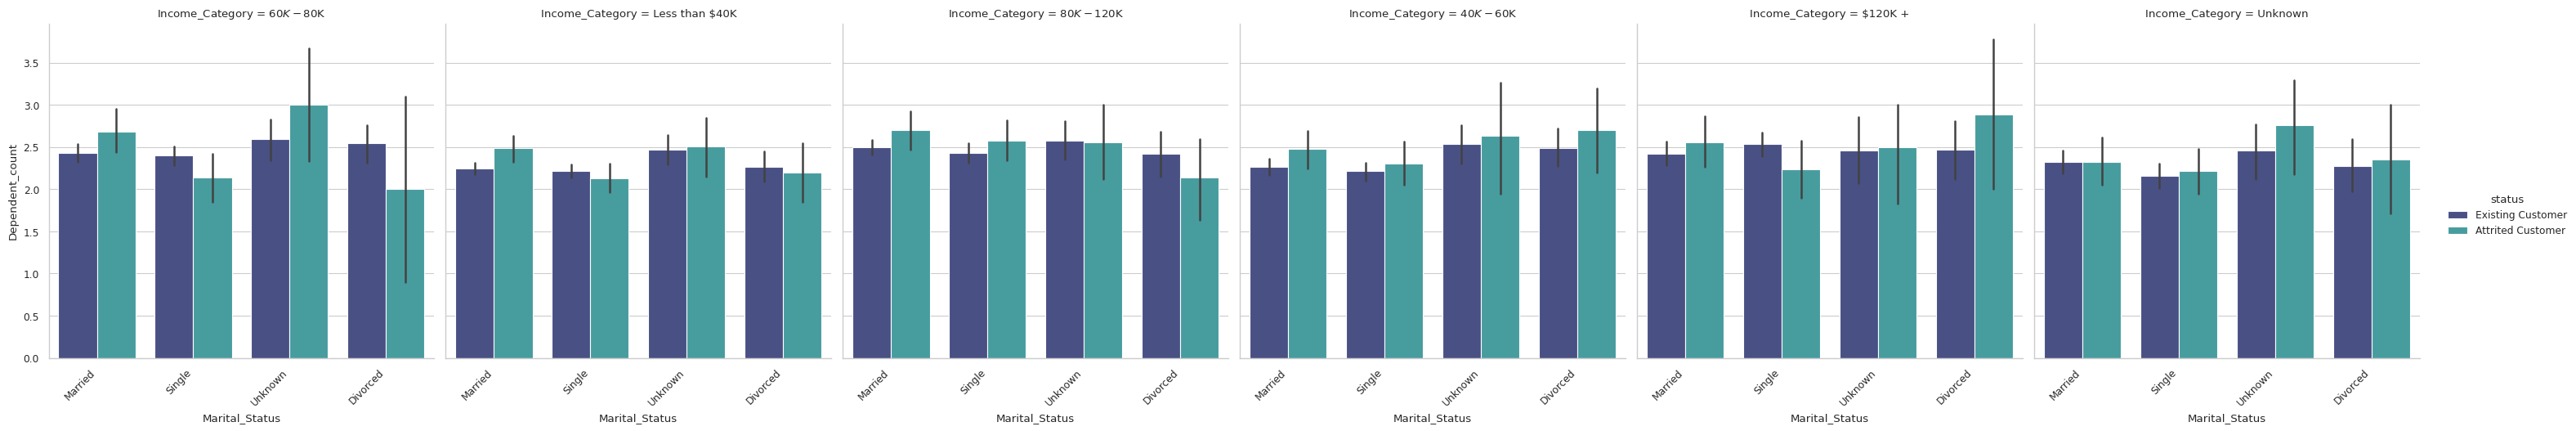

In [467]:
fig = sns.catplot(x = 'Marital_Status',
            y = 'Dependent_count',
            hue = 'status',
            col = 'Income_Category',
            kind = 'bar', palette = 'mako',
            data = df)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

In [468]:
df_income1 = df.groupby(by=['Income_Category','Marital_Status','status']).agg(avg_dependent_cnt=('Dependent_count','mean')).sort_values(by=['Income_Category','Marital_Status','status','avg_dependent_cnt'],ascending=True).reset_index()
df_income1.style.background_gradient(cmap='BuGn')

,Income_Category,Marital_Status,status,avg_dependent_cnt
0,$120K +,Divorced,Attrited Customer,2.888889
1,$120K +,Divorced,Existing Customer,2.465116
2,$120K +,Married,Attrited Customer,2.557692
3,$120K +,Married,Existing Customer,2.423841
4,$120K +,Single,Attrited Customer,2.237288
5,$120K +,Single,Existing Customer,2.534884
6,$120K +,Unknown,Attrited Customer,2.500000
7,$120K +,Unknown,Existing Customer,2.463415
8,$40K - $60K,Divorced,Attrited Customer,2.700000
9,$40K - $60K,Divorced,Existing Customer,2.491525


2. Income Category, Average Utilization Ratio, Marital Status, Customer Status

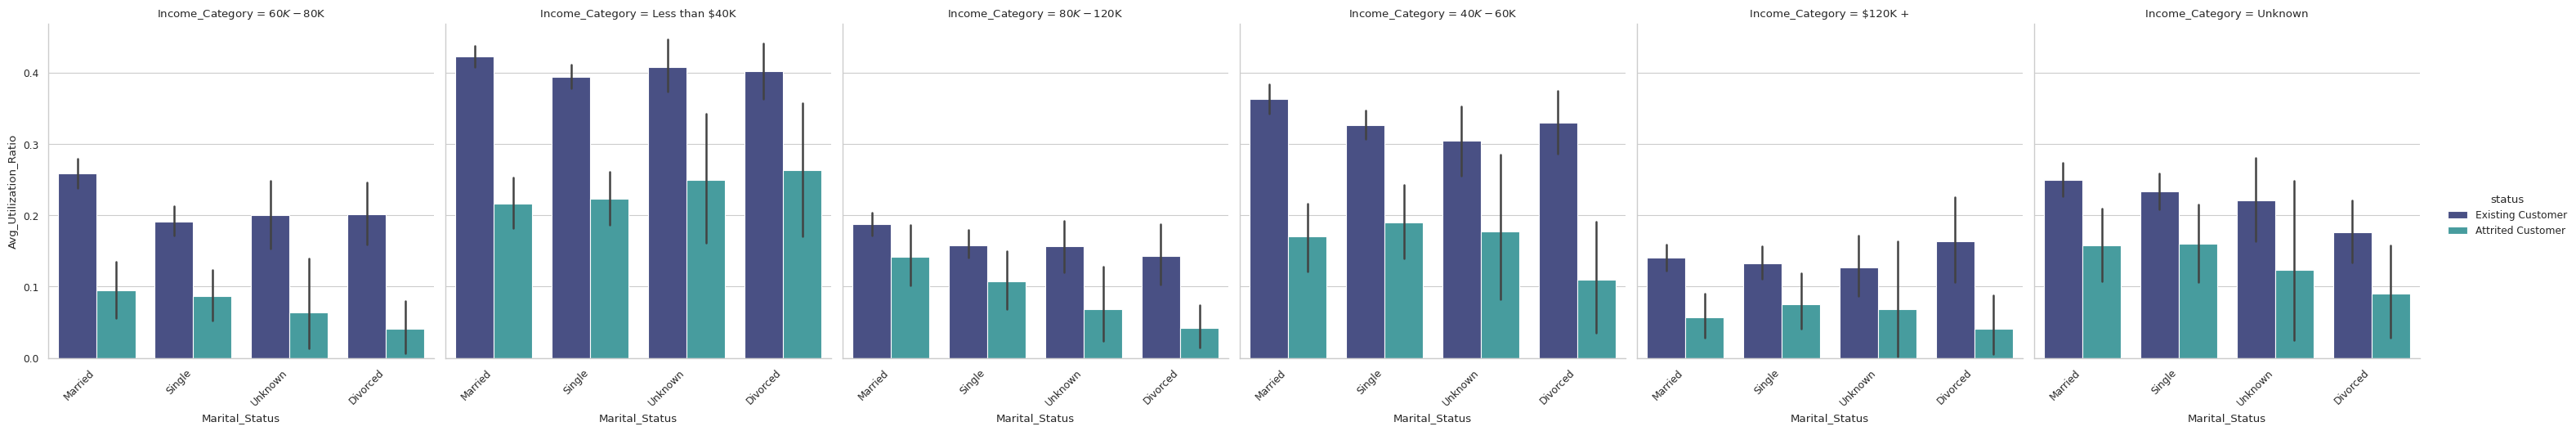

In [469]:
fig = sns.catplot(x = 'Marital_Status',
            y = 'Avg_Utilization_Ratio',
            hue = 'status',
            col = 'Income_Category',
            kind = 'bar', palette = 'mako',
            data = df)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

In [470]:
df_income2 = df.groupby(by=['Income_Category','Marital_Status','status']).agg(avg_util_ratio=('Avg_Utilization_Ratio','mean')).sort_values(by=['Income_Category','Marital_Status','status','avg_util_ratio'],ascending=True).reset_index()
df_income2.style.background_gradient(cmap='BuGn')

,Income_Category,Marital_Status,status,avg_util_ratio
0,$120K +,Divorced,Attrited Customer,0.041000
1,$120K +,Divorced,Existing Customer,0.163209
2,$120K +,Married,Attrited Customer,0.056615
3,$120K +,Married,Existing Customer,0.140017
4,$120K +,Single,Attrited Customer,0.074746
5,$120K +,Single,Existing Customer,0.132414
6,$120K +,Unknown,Attrited Customer,0.068000
7,$120K +,Unknown,Existing Customer,0.126707
8,$40K - $60K,Divorced,Attrited Customer,0.109200
9,$40K - $60K,Divorced,Existing Customer,0.330297


3. Income Category, Credit Limit, Marital Status, Customer Status

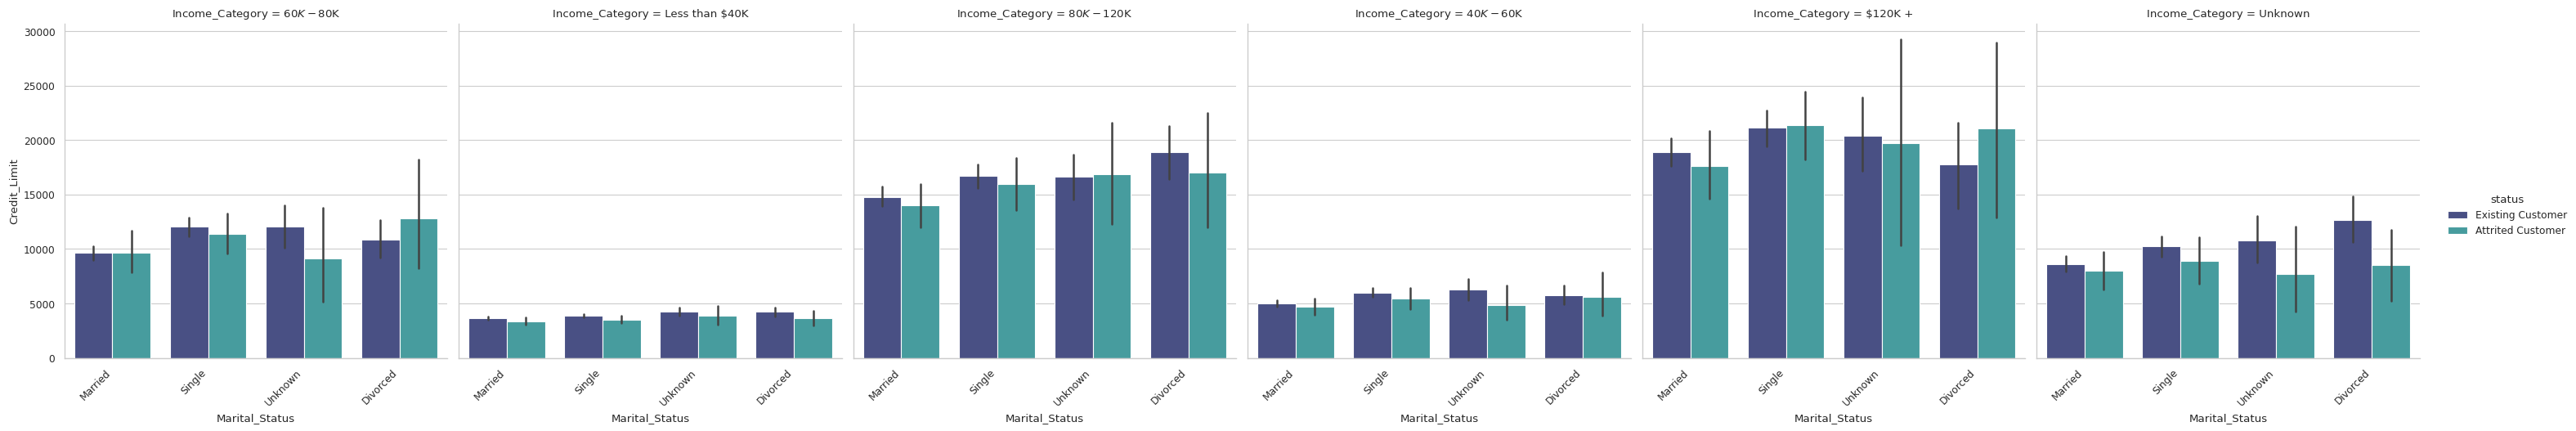

In [471]:
fig = sns.catplot(x = 'Marital_Status',
            y = 'Credit_Limit',
            hue = 'status',
            col = 'Income_Category',
            kind = 'bar', palette = 'mako',
            data = df)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

In [472]:
df_income3 = df.groupby(by=['Income_Category','Marital_Status','status']).agg(avg_credit_limit=('Credit_Limit','mean')).sort_values(by=['Income_Category','Marital_Status','status','avg_credit_limit'],ascending=True).reset_index()
df_income3.style.background_gradient(cmap='BuGn')

,Income_Category,Marital_Status,status,avg_credit_limit
0,$120K +,Divorced,Attrited Customer,21071.333333
1,$120K +,Divorced,Existing Customer,17751.162791
2,$120K +,Married,Attrited Customer,17625.384615
3,$120K +,Married,Existing Customer,18869.986755
4,$120K +,Single,Attrited Customer,21394.593220
5,$120K +,Single,Existing Customer,21163.023256
6,$120K +,Unknown,Attrited Customer,19681.500000
7,$120K +,Unknown,Existing Customer,20387.170732
8,$40K - $60K,Divorced,Attrited Customer,5603.500000
9,$40K - $60K,Divorced,Existing Customer,5777.050847


4. Income Category, Average Open To Buy, Marital Status, Customer Status

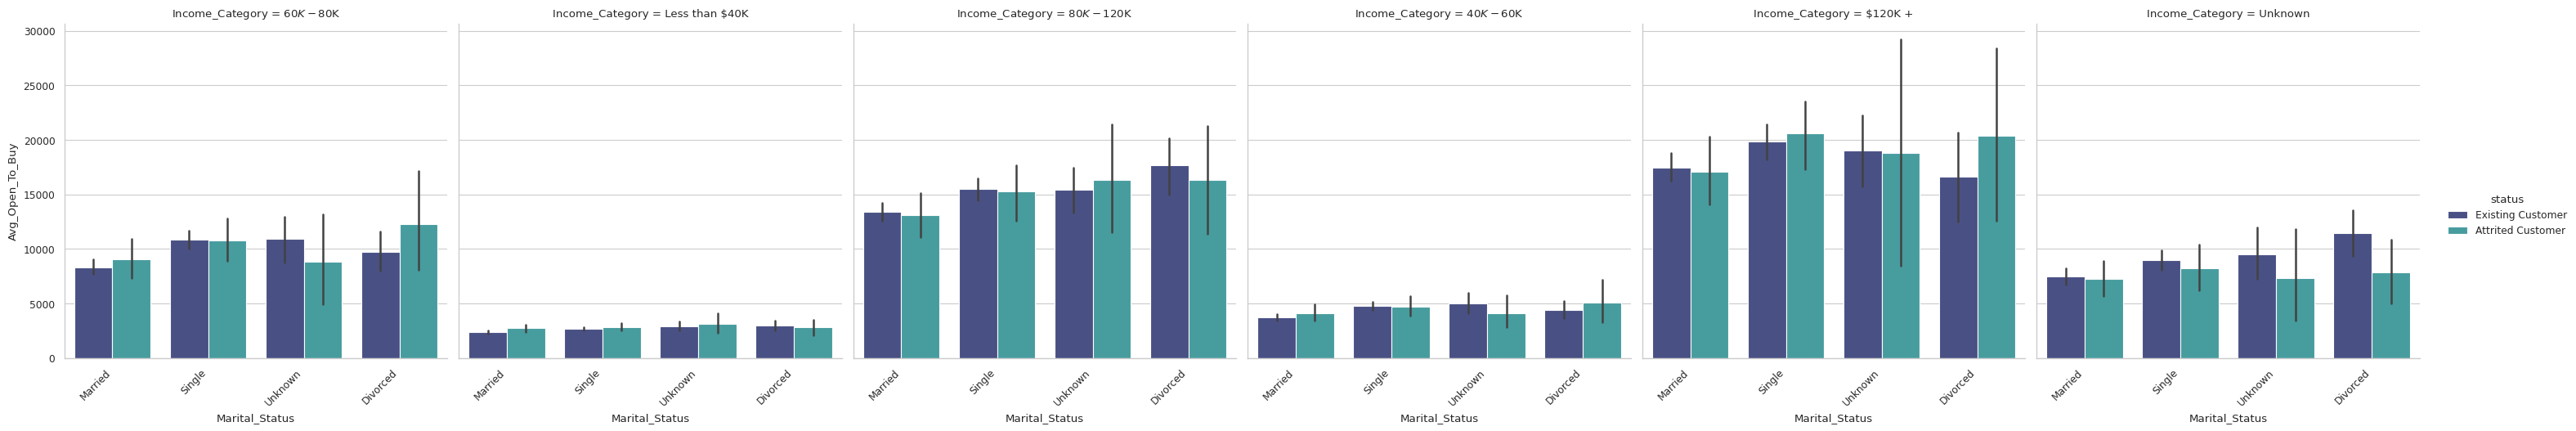

In [473]:
fig = sns.catplot(x = 'Marital_Status',
            y = 'Avg_Open_To_Buy',
            hue = 'status',
            col = 'Income_Category',
            kind = 'bar', palette = 'mako',
            data = df)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

In [474]:
df_income4 = df.groupby(by=['Income_Category','Marital_Status','status']).agg(avg_opentobuy=('Avg_Open_To_Buy','mean')).sort_values(by=['Income_Category','Marital_Status','status','avg_opentobuy'],ascending=True).reset_index()
df_income4.style.background_gradient(cmap='BuGn')

,Income_Category,Marital_Status,status,avg_opentobuy
0,$120K +,Divorced,Attrited Customer,20390.222222
1,$120K +,Divorced,Existing Customer,16619.162791
2,$120K +,Married,Attrited Customer,17093.500000
3,$120K +,Married,Existing Customer,17483.500000
4,$120K +,Single,Attrited Customer,20607.559322
5,$120K +,Single,Existing Customer,19866.920930
6,$120K +,Unknown,Attrited Customer,18817.500000
7,$120K +,Unknown,Existing Customer,18995.146341
8,$40K - $60K,Divorced,Attrited Customer,5038.950000
9,$40K - $60K,Divorced,Existing Customer,4381.101695


5. Income Category, Total Transaction Amount, Marital Status, Customer Status

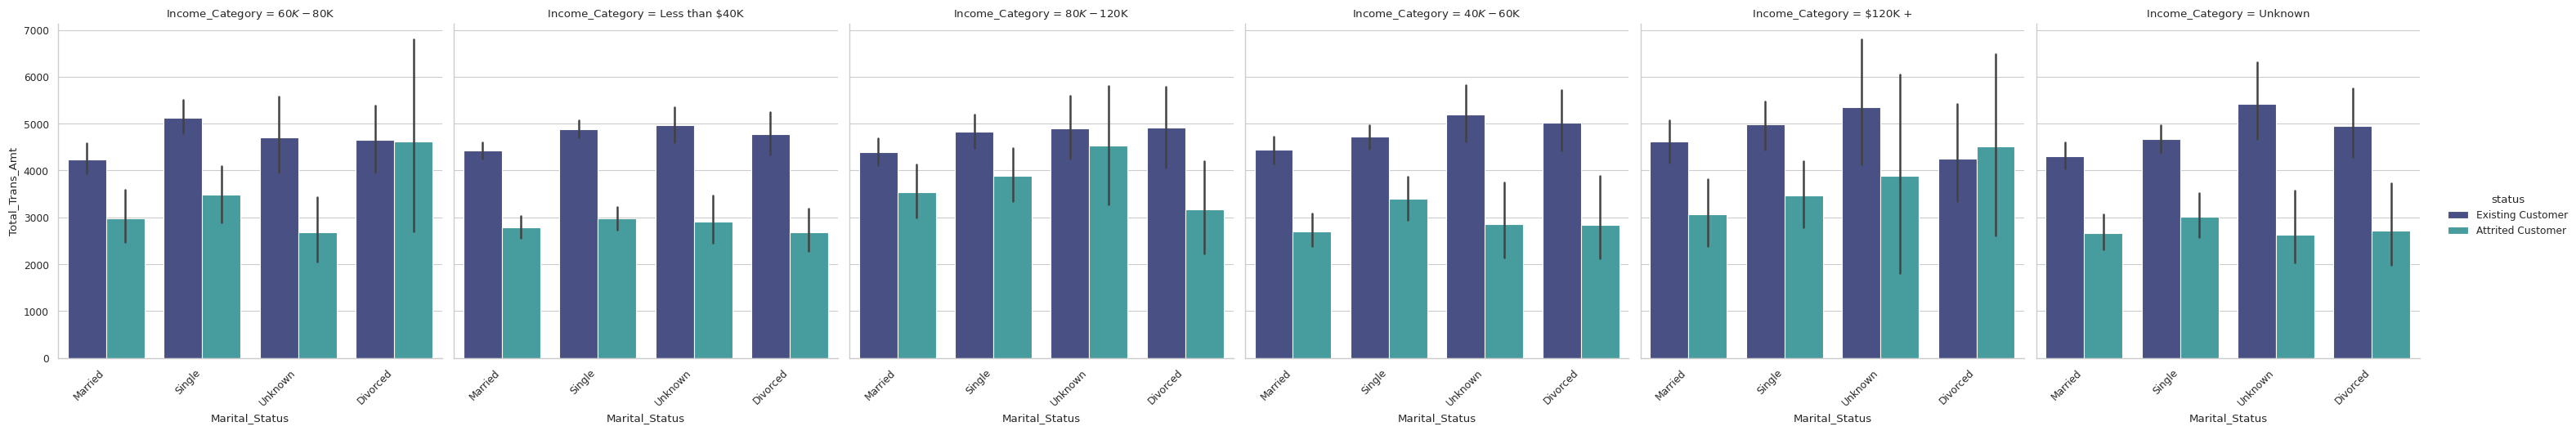

In [475]:
fig = sns.catplot(x = 'Marital_Status',
            y = 'Total_Trans_Amt',
            hue = 'status',
            col = 'Income_Category',
            kind = 'bar', palette = 'mako',
            data = df)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

# **Data Cleaning**

**Detecting Duplicate Data**

In [476]:
df_train = df.copy()

In [477]:
print('The number of duplicate data is:',df_train.duplicated().sum())
# there is no duplication

The number of duplicate data is: 0


In [478]:
# check for empty elements
print('Missing values status:', df_train.isnull().values.any())
df_null = pd.DataFrame(df_train.isnull().sum(), columns=['Total Null Values'])
df_null['Percentage'] = (df_null['Total Null Values']/df.shape[0])*100
df_null = df_null.sort_values(by=['Percentage'], ascending=False).reset_index()
df_null

Missing values status: False


,index,Total Null Values,Percentage
0,CLIENTNUM,0,0.0
1,Card_Category,0,0.0
2,Total_Trans_Ct,0,0.0
3,Total_Trans_Amt,0,0.0
4,Avg_Open_To_Buy,0,0.0
5,Total_Revolving_Bal,0,0.0
6,Credit_Limit,0,0.0
7,Contacts_Count_12_mon,0,0.0
8,Months_Inactive_12_mon,0,0.0
9,Total_Relationship_Count,0,0.0


In [479]:
df_train.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   idstatus                  10127 non-null  int64  
 2   status                    10127 non-null  object 
 3   Customer_Age              10127 non-null  int64  
 4   Gender                    10127 non-null  object 
 5   Dependent_count           10127 non-null  int64  
 6   Educationid               10127 non-null  int64  
 7   Education_Level           10127 non-null  object 
 8   Maritalid                 10127 non-null  int64  
 9   Marital_Status            10127 non-null  object 
 10  Income_Category           10127 non-null  object 
 11  card_categoryid           10127 non-null  int64  
 12  Card_Category             10127 non-null  object 
 13  Months_on_book            10127 non-null  int64  
 14  Total_

In [480]:
#drop unecessary column
df_train = df_train.drop(columns=['idstatus','Educationid','Maritalid','card_categoryid'])
df.head()

,CLIENTNUM,idstatus,status,Customer_Age,Gender,Dependent_count,Educationid,Education_Level,Maritalid,Marital_Status,Income_Category,card_categoryid,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Trans_Amt,Total_Trans_Ct,Avg_Utilization_Ratio
0,768805383,1,Existing Customer,45,Male,3,1,High School,1,Married,$60K - $80K,1,Blue,39,5,1,3,12691,777,11914,1144,42,0.061
1,818770008,1,Existing Customer,49,Female,5,2,Graduate,2,Single,Less than $40K,1,Blue,44,6,1,2,8256,864,7392,1291,33,0.105
2,713982108,1,Existing Customer,51,Male,3,2,Graduate,1,Married,$80K - $120K,1,Blue,36,4,1,0,3418,0,3418,1887,20,0.000
3,769911858,1,Existing Customer,40,Female,4,1,High School,3,Unknown,Less than $40K,1,Blue,34,3,4,1,3313,2517,796,1171,20,0.760
4,709106358,1,Existing Customer,40,Male,3,3,Uneducated,1,Married,$60K - $80K,1,Blue,21,5,1,0,4716,0,4716,816,28,0.000


In [481]:
#dataset info after dropping unecassary column
df_train.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   status                    10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  int64  
 14  Total_

In [482]:
# dataset that only consist numerical features [1]
int_features = df_train[['Customer_Age','Dependent_count', 'Months_on_book', 'Total_Relationship_Count']]

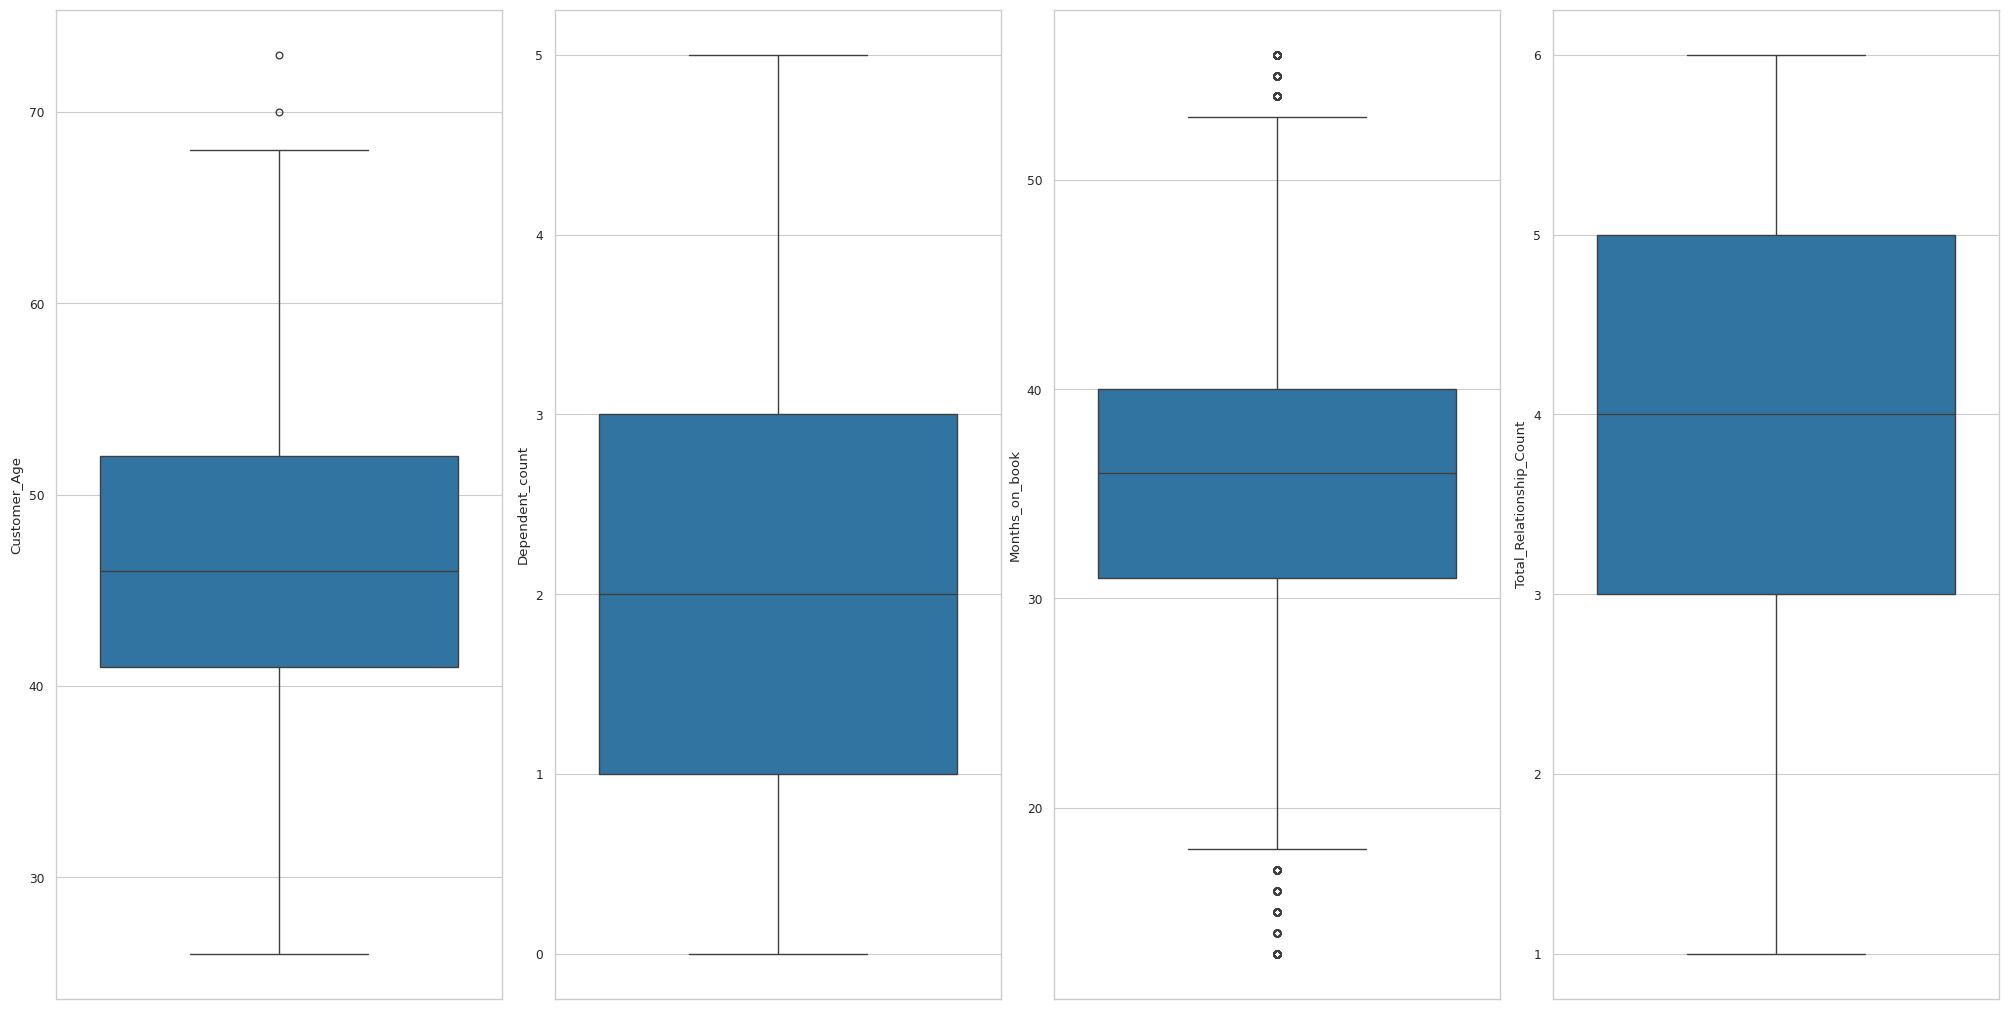

In [483]:
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [484]:
# dataset that only consist numerical features [2]
int_features = df_train[['Contacts_Count_12_mon','Credit_Limit', 'Total_Revolving_Bal', 'Months_Inactive_12_mon']]

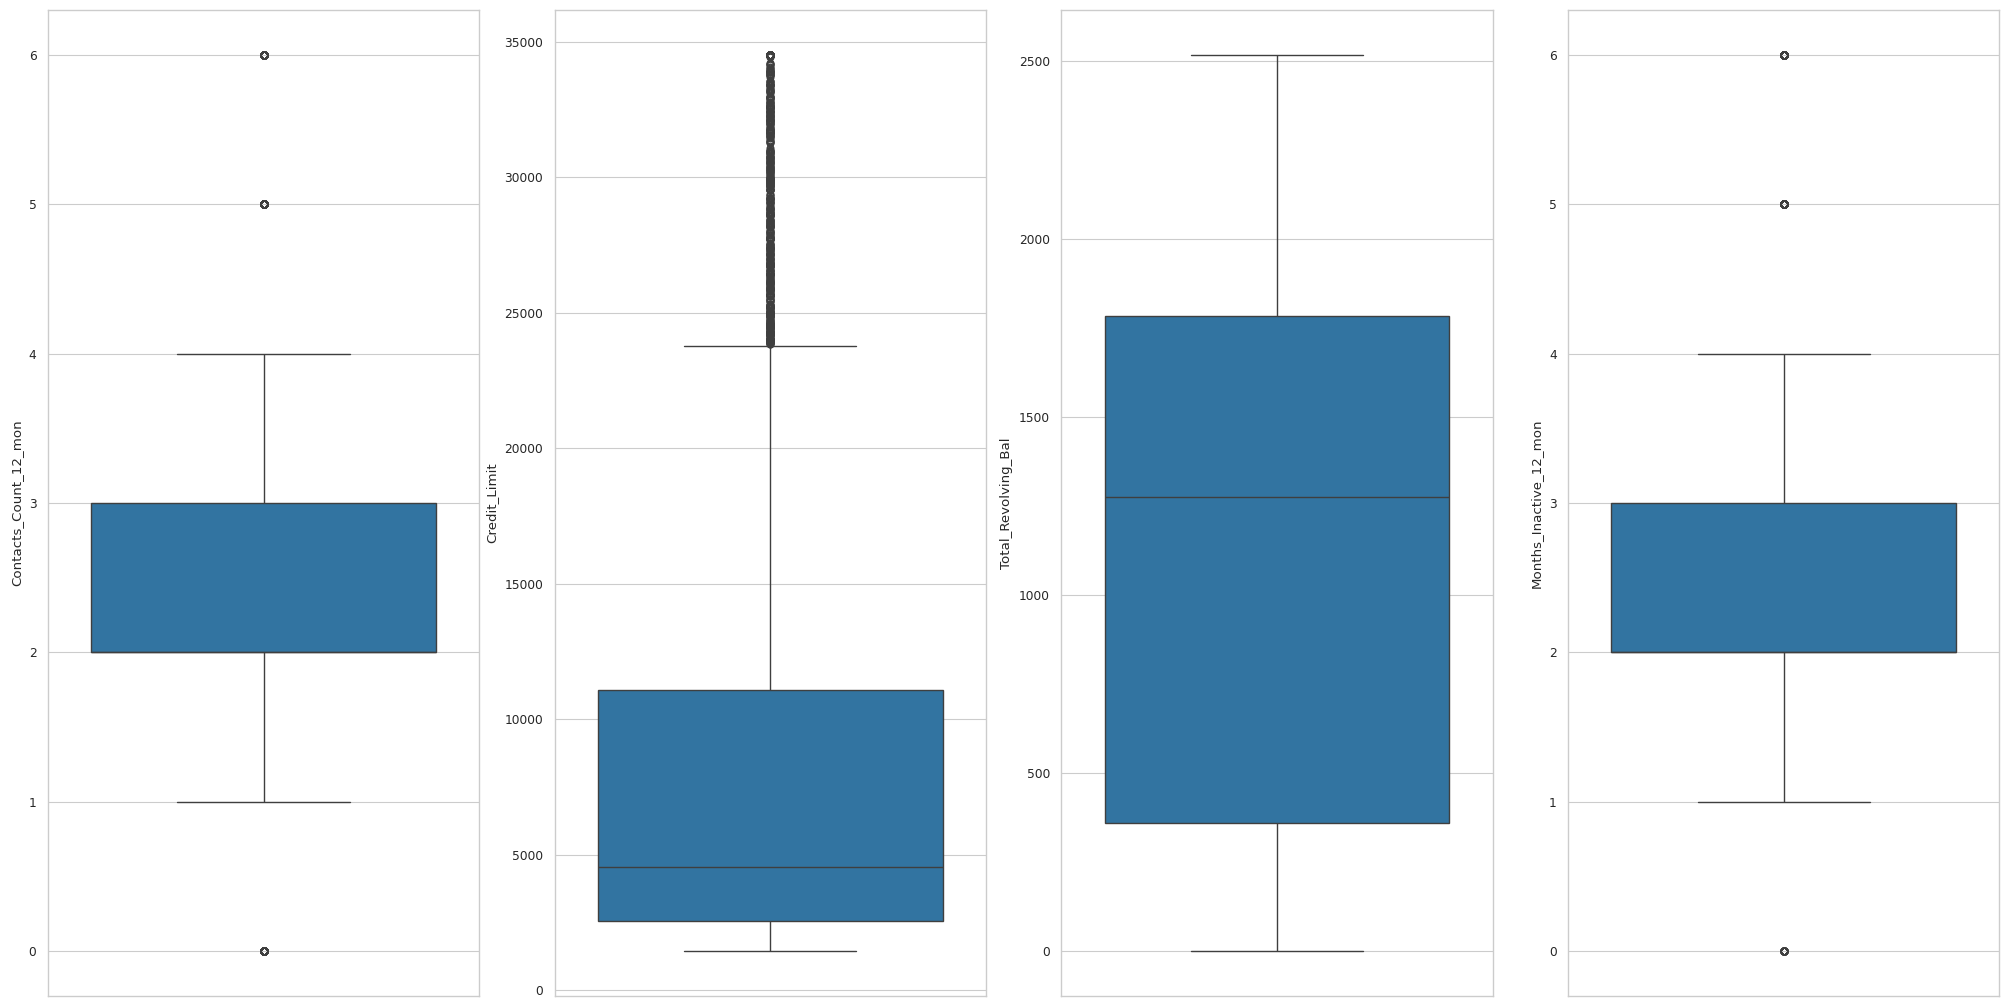

In [485]:
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [486]:
# dataset that only consist numerical features [3]
int_features = df_train[['Avg_Open_To_Buy','Total_Trans_Amt', 'Total_Trans_Ct', 'Avg_Utilization_Ratio']]

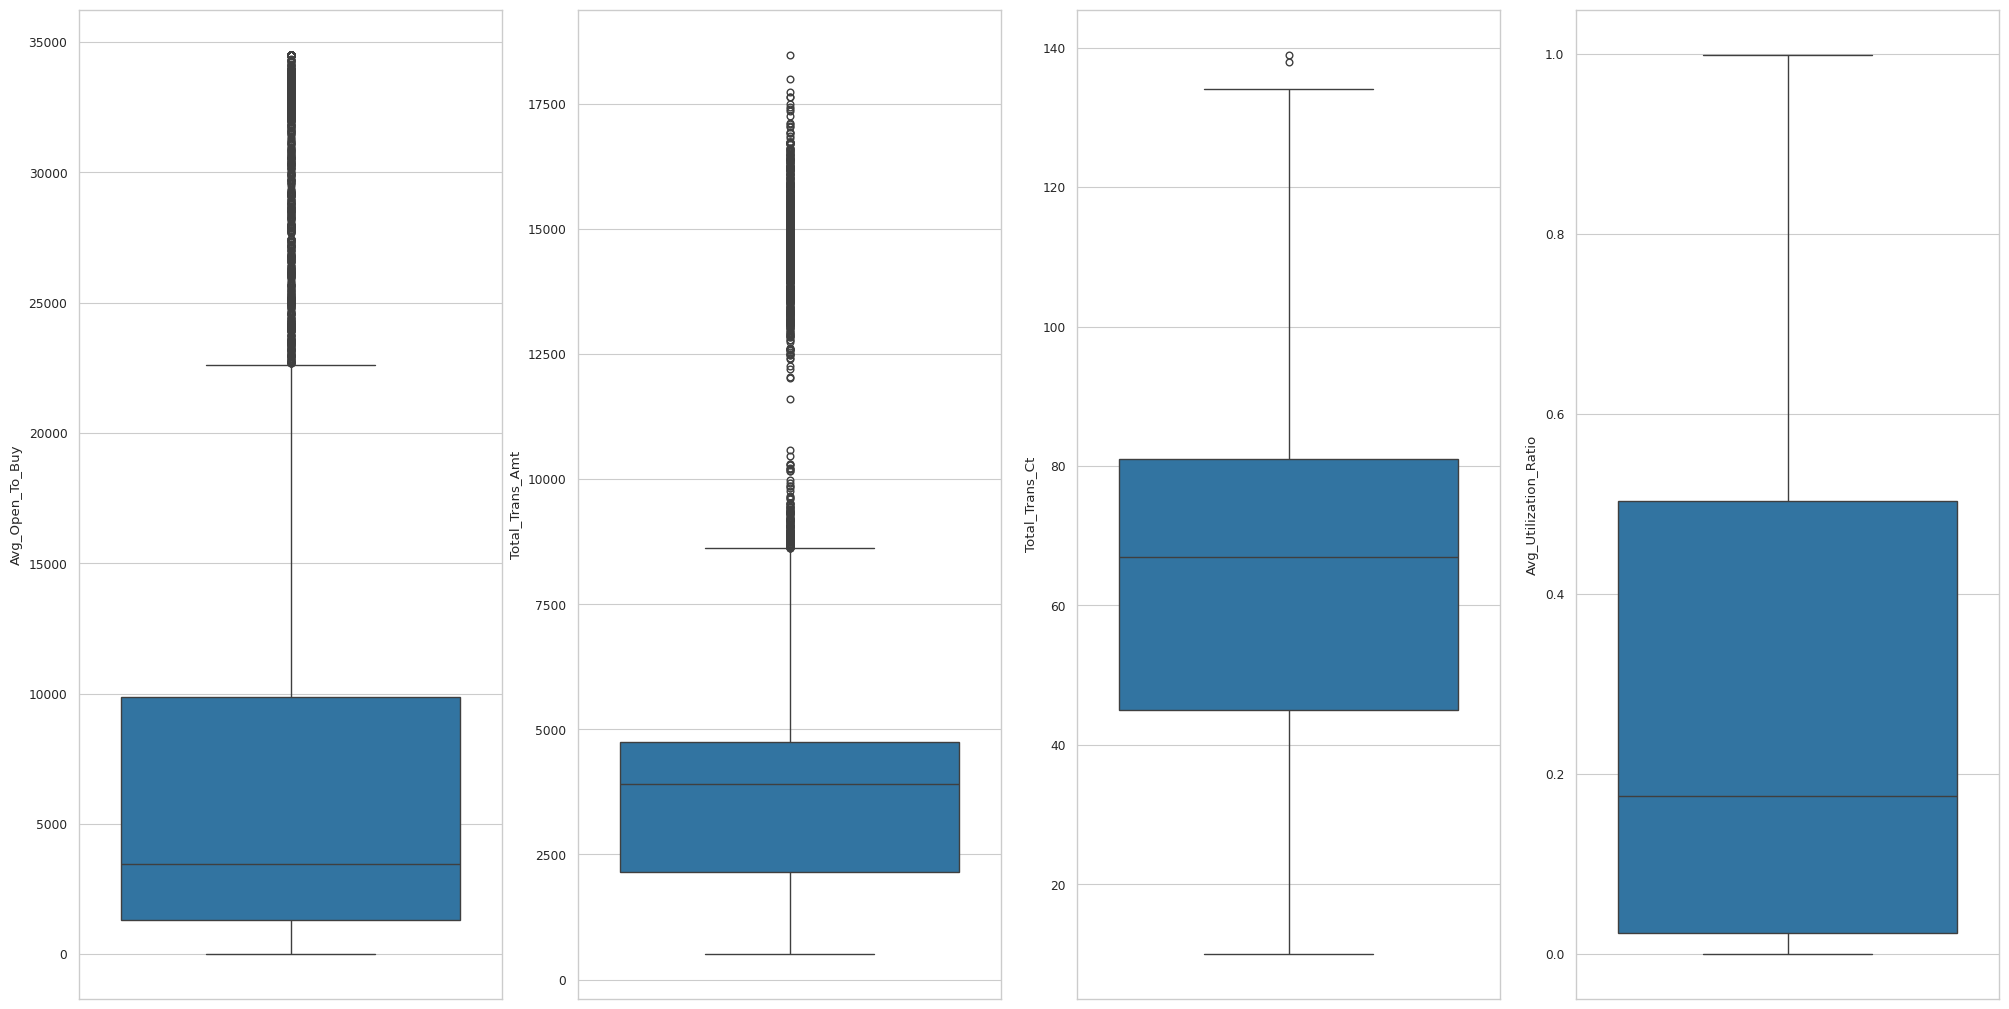

In [487]:
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

**Data Preprocessing**

Encode Features

In [488]:
cleaned_df_train = df_train.drop(['CLIENTNUM'], axis=1)

from sklearn.preprocessing import LabelEncoder
#Convert all the non-numeric columns to numerical data types
for column in cleaned_df_train.columns:
    if cleaned_df_train[column].dtype == np.number: continue
    # Perform encoding for each non-numeric column
    cleaned_df_train[column] = LabelEncoder().fit_transform(cleaned_df_train[column])
print(cleaned_df_train.describe())

             status  Customer_Age        Gender  Dependent_count  \
count  10127.000000  10127.000000  10127.000000     10127.000000   
mean       0.839340     20.325565      0.470919         2.346203   
std        0.367235      8.015598      0.499178         1.298908   
min        0.000000      0.000000      0.000000         0.000000   
25%        1.000000     15.000000      0.000000         1.000000   
50%        1.000000     20.000000      0.000000         2.000000   
75%        1.000000     26.000000      1.000000         3.000000   
max        1.000000     44.000000      1.000000         5.000000   

       Education_Level  Marital_Status  Income_Category  Card_Category  \
count     10127.000000    10127.000000     10127.000000   10127.000000   
mean          3.096574        1.463415         2.863928       0.179816   
std           1.834812        0.737808         1.504700       0.693039   
min           0.000000        0.000000         0.000000       0.000000   
25%           2.0

In [489]:
cleaned_df_train.head()

,status,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Trans_Amt,Total_Trans_Ct,Avg_Utilization_Ratio
0,1,19,1,3,3,1,2,0,26,4,1,3,4623,324,4792,217,32,0.061
1,1,23,0,5,2,2,4,0,31,5,1,2,3623,408,3806,338,23,0.105
2,1,25,1,3,2,1,3,0,23,3,1,0,1623,0,2342,893,10,0.000
3,1,14,0,4,3,3,4,0,21,2,4,1,1552,1973,575,236,10,0.760
4,1,14,1,3,5,1,2,0,8,4,1,0,2363,0,2946,65,18,0.000


**Feature Selection**

In [490]:
x = cleaned_df_train.drop(['status'], axis=1)
y = cleaned_df_train['status']

In [491]:
# feature selection
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Features', 'Score']
print('The features that correlate well with target feature:\n')
featureScores.sort_values(by=['Score'], ascending=False)

The features that correlate well with target feature:



,Features,Score
14,Total_Trans_Amt,402859.825865
12,Total_Revolving_Bal,279458.385229
11,Credit_Limit,27492.215069
15,Total_Trans_Ct,14027.238006
13,Avg_Open_To_Buy,2208.104454
10,Contacts_Count_12_mon,211.039445
8,Total_Relationship_Count,195.738278
9,Months_Inactive_12_mon,102.667123
16,Avg_Utilization_Ratio,89.116891
0,Customer_Age,10.634558


It can be seen which features correlate well with payment difficulties.
1.   **Best features**: CLIENTNUM, Total_Trans_Amt, Total_Revolving_Bal, Credit_Limit,Total_Trans_Ct
2.   **Worst features**: Education_Level, Card_Category, Marital_Status, Income_Category and Dependent_count

But, I use all features to continue the next analysis because this dataset has few features

**Data Splitting**

In [492]:
# splitting tha data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(8101, 17) (2026, 17)


In [493]:
# Print according to the expected result
print('Jumlah baris dan kolom dari x_train adalah:', X_train.shape,', sedangkan Jumlah baris dan kolom dari y_train adalah:', y_train.shape)
print('Prosentase Churn di data Training adalah:')
print(y_train.value_counts(normalize=True))
print('Jumlah baris dan kolom dari x_test adalah:', X_test.shape,', sedangkan Jumlah baris dan kolom dari y_test adalah:', y_test.shape)
print('Prosentase Churn di data Testing adalah:')
print(y_test.value_counts(normalize=True))

Jumlah baris dan kolom dari x_train adalah: (8101, 17) , sedangkan Jumlah baris dan kolom dari y_train adalah: (8101,)
Prosentase Churn di data Training adalah:
status
1    0.839526
0    0.160474
Name: proportion, dtype: float64
Jumlah baris dan kolom dari x_test adalah: (2026, 17) , sedangkan Jumlah baris dan kolom dari y_test adalah: (2026,)
Prosentase Churn di data Testing adalah:
status
1    0.838598
0    0.161402
Name: proportion, dtype: float64


In [494]:
# normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

**Model Building**

Here are some algorithms that will be tested to determine the best model:

1.   Logistic Regression
2.   Gaussian Naive Bayes
3.   Decision Tree
4.   Random Forest

**1. Logistic Regression**

In [495]:
# train the model
log_model = LogisticRegression().fit(X_train, y_train)
print(log_model)

LogisticRegression()


In [496]:
# predict data train
y_train_pred_log = log_model.predict(X_train)

# print classification report
print('Classification Report Training Model (Logistic Regression):')
print(classification_report(y_train, y_train_pred_log))

Classification Report Training Model (Logistic Regression):
              precision    recall  f1-score   support

           0       0.75      0.55      0.64      1300
           1       0.92      0.96      0.94      6801

    accuracy                           0.90      8101
   macro avg       0.83      0.76      0.79      8101
weighted avg       0.89      0.90      0.89      8101



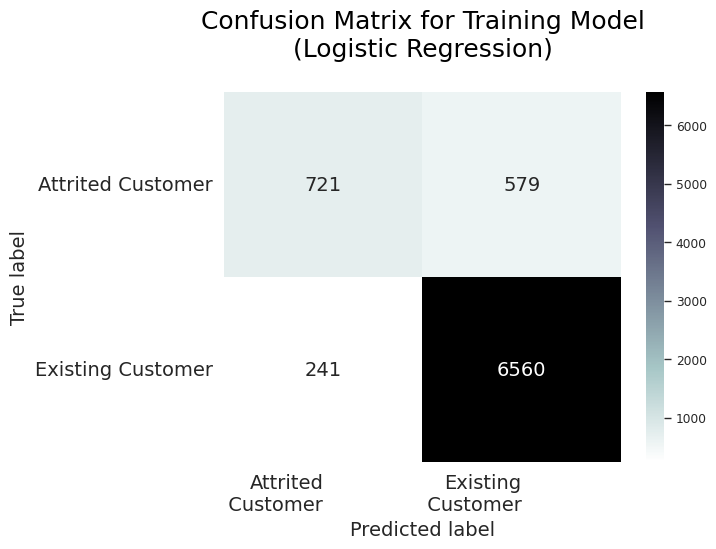

In [497]:
# form confusion matrix as a dataFrame
confusion_matrix_log = pd.DataFrame((confusion_matrix(y_train, y_train_pred_log)), ('Attrited Customer', 'Existing Customer'), ('Attrited\n Customer', 'Existing\n Customer'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_log, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Logistic Regression)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [498]:
# predict data test
y_test_pred_log = log_model.predict(X_test)

# print classification report
print('Classification Report Testing Model (Logistic Regression):')
print(classification_report(y_test, y_test_pred_log))

Classification Report Testing Model (Logistic Regression):
              precision    recall  f1-score   support

           0       0.71      0.49      0.58       327
           1       0.91      0.96      0.93      1699

    accuracy                           0.89      2026
   macro avg       0.81      0.73      0.76      2026
weighted avg       0.88      0.89      0.88      2026



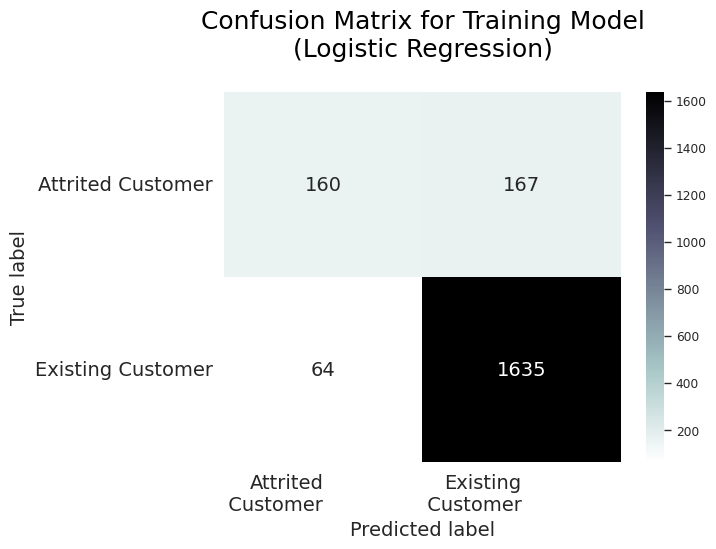

In [499]:
# form confusion matrix as a dataFrame
confusion_matrix_log = pd.DataFrame((confusion_matrix(y_test, y_test_pred_log)), ('Attrited Customer', 'Existing Customer'), ('Attrited\n Customer', 'Existing\n Customer'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_log, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Logistic Regression)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [500]:
acc_log_train=round(log_model.score(X_train,y_train)*100,2)
acc_log_test=round(log_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_log_train))
print("Test Accuracy: % {}".format(acc_log_test))

Training Accuracy: % 89.88
Test Accuracy: % 88.6


In [501]:
# ROC scores
roc_auc_log = round(roc_auc_score(y_test, y_test_pred_log),4)
print('ROC AUC:', roc_auc_log)

ROC AUC: 0.7258


**2. Gaussian Naive Bayes**

In [502]:
# train the model
gnb_model = GaussianNB().fit(X_train, y_train)
print(gnb_model)

GaussianNB()


In [503]:
# predict data train
y_train_pred_gnb = gnb_model.predict(X_train)

# print classification report
print('Classification Report Training Model (Gaussian Naive Bayes):')
print(classification_report(y_train, y_train_pred_gnb))

Classification Report Training Model (Gaussian Naive Bayes):
              precision    recall  f1-score   support

           0       0.61      0.60      0.61      1300
           1       0.92      0.93      0.93      6801

    accuracy                           0.87      8101
   macro avg       0.77      0.76      0.77      8101
weighted avg       0.87      0.87      0.87      8101



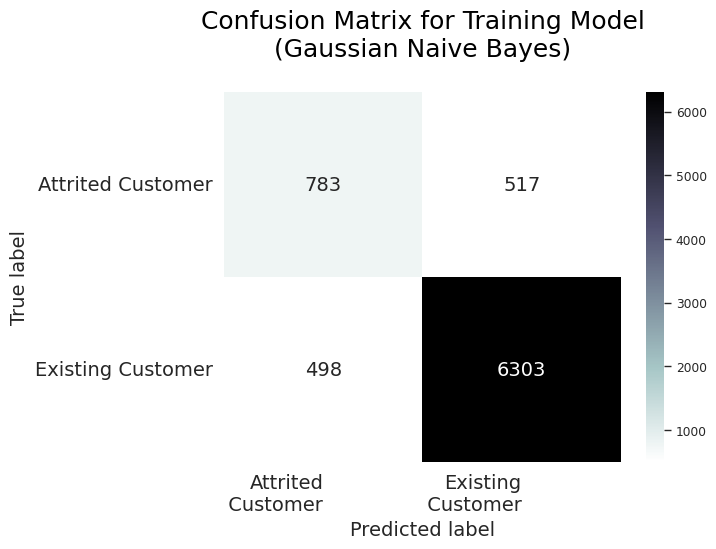

In [504]:
# form confusion matrix as a dataFrame
confusion_matrix_gnb = pd.DataFrame((confusion_matrix(y_train, y_train_pred_gnb)), ('Attrited Customer', 'Existing Customer'), ('Attrited\n Customer', 'Existing\n Customer'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_gnb, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Gaussian Naive Bayes)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [505]:
# predict data test
y_test_pred_gnb = gnb_model.predict(X_test)

# print classification report
print('Classification Report Testing Model (Gaussian Naive Bayes):')
print(classification_report(y_test, y_test_pred_gnb))

Classification Report Testing Model (Gaussian Naive Bayes):
              precision    recall  f1-score   support

           0       0.60      0.51      0.55       327
           1       0.91      0.93      0.92      1699

    accuracy                           0.87      2026
   macro avg       0.75      0.72      0.74      2026
weighted avg       0.86      0.87      0.86      2026



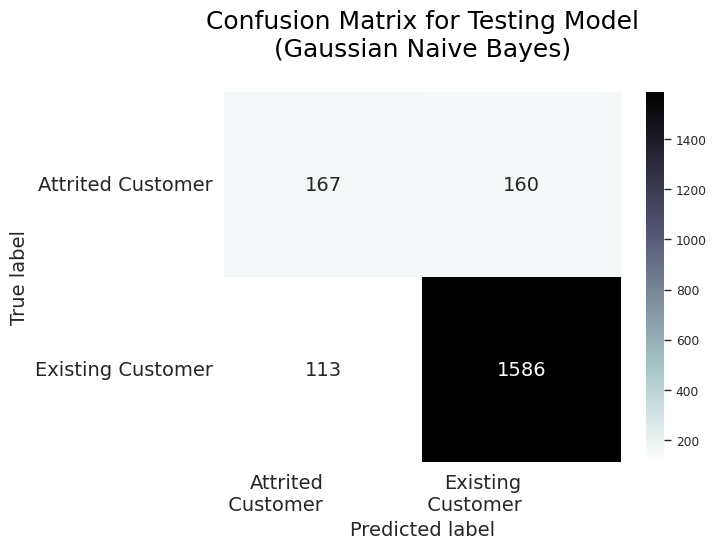

In [506]:
# form confusion matrix as a dataFrame
confusion_matrix_gnb = pd.DataFrame((confusion_matrix(y_test, y_test_pred_gnb)), ('Attrited Customer', 'Existing Customer'), ('Attrited\n Customer', 'Existing\n Customer'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_gnb, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Gaussian Naive Bayes)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [507]:
acc_nb_train=round(gnb_model.score(X_train,y_train)*100,2)
acc_nb_test=round(gnb_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_nb_train))
print("Test Accuracy: % {}".format(acc_nb_test))

Training Accuracy: % 87.47
Test Accuracy: % 86.53


In [508]:
# ROC scores
roc_auc_gnb = round(roc_auc_score(y_test, y_test_pred_gnb),4)
print('ROC AUC:', roc_auc_gnb)

ROC AUC: 0.7221


**3. Decision Tree**

In [509]:
# train the model
dt_model = DecisionTreeClassifier().fit(X_train,y_train)
print(dt_model)

DecisionTreeClassifier()


In [510]:
# predict data train
y_train_pred_dt = dt_model.predict(X_train)

# print classification report
print('Classification Report Training Model (Decision Tree Classifier):')
print(classification_report(y_train, y_train_pred_dt))

Classification Report Training Model (Decision Tree Classifier):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1300
           1       1.00      1.00      1.00      6801

    accuracy                           1.00      8101
   macro avg       1.00      1.00      1.00      8101
weighted avg       1.00      1.00      1.00      8101



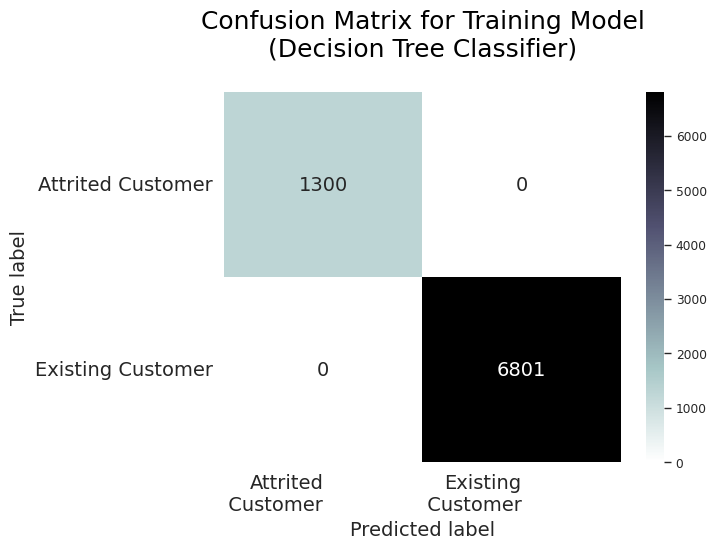

In [511]:
# form confusion matrix as a dataFrame
confusion_matrix_dt = pd.DataFrame((confusion_matrix(y_train, y_train_pred_dt)), ('Attrited Customer', 'Existing Customer'), ('Attrited\n Customer', 'Existing\n Customer'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_dt, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Decision Tree Classifier)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [512]:
# predict data test
y_test_pred_dt = dt_model.predict(X_test)

# print classification report
print('Classification Report Testing Model (Decision Tree Classifier):')
print(classification_report(y_test, y_test_pred_dt))

Classification Report Testing Model (Decision Tree Classifier):
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       327
           1       0.96      0.96      0.96      1699

    accuracy                           0.93      2026
   macro avg       0.87      0.87      0.87      2026
weighted avg       0.93      0.93      0.93      2026



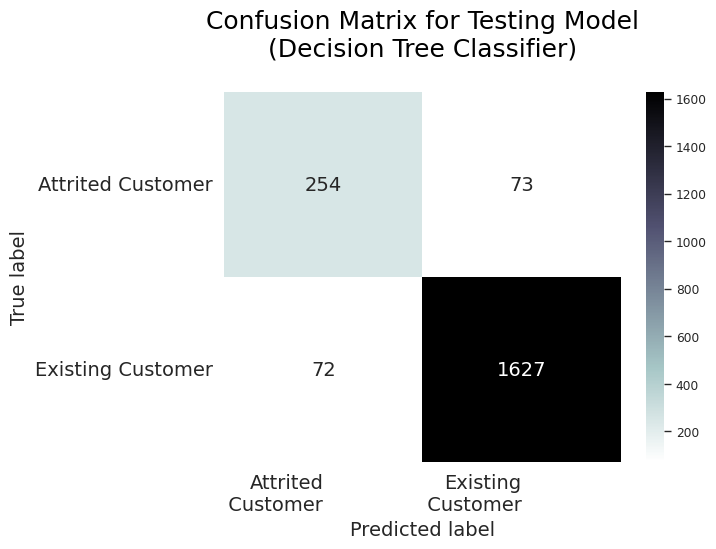

In [513]:
# form confusion matrix as a dataFrame
confusion_matrix_dt = pd.DataFrame((confusion_matrix(y_test, y_test_pred_dt)), ('Attrited Customer', 'Existing Customer'), ('Attrited\n Customer', 'Existing\n Customer'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_dt, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Decision Tree Classifier)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [514]:
acc_dt_train=round(dt_model.score(X_train,y_train)*100,2)
acc_dt_test=round(dt_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_dt_train))
print("Test Accuracy: % {}".format(acc_dt_test))

Training Accuracy: % 100.0
Test Accuracy: % 92.84


In [515]:
# ROC scores
roc_auc_dt = round(roc_auc_score(y_test, y_test_pred_dt),4)
print('ROC AUC:', roc_auc_dt)

ROC AUC: 0.8672


**4. Gradient Boosting Classifier**

In [516]:
gbt_model=GradientBoostingClassifier().fit(X_train,y_train)
print(gbt_model)

GradientBoostingClassifier()


In [517]:
# Predict data train
y_train_pred_gbt = gbt_model.predict(X_train)
# Print classification report
print('Classification Report Training Model (Gradient Boosting):')
print(classification_report(y_train,y_train_pred_gbt))

Classification Report Training Model (Gradient Boosting):
              precision    recall  f1-score   support

           0       0.93      0.84      0.88      1300
           1       0.97      0.99      0.98      6801

    accuracy                           0.96      8101
   macro avg       0.95      0.92      0.93      8101
weighted avg       0.96      0.96      0.96      8101



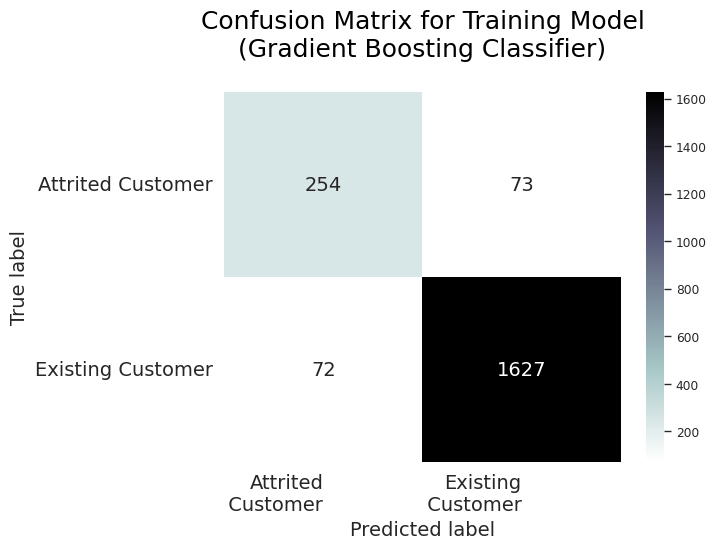

In [518]:
# form confusion matrix as a dataFrame
confusion_matrix_gbt = pd.DataFrame((confusion_matrix(y_train, y_train_pred_gbt)), ('Attrited Customer', 'Existing Customer'), ('Attrited\n Customer', 'Existing\n Customer'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_dt, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Gradient Boosting Classifier)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [519]:
# Predict
y_test_pred_gbt = gbt_model.predict(X_test)
# Print classification report
print('Classification Report Testing Model (Gradient Boosting):')
print(classification_report(y_test,y_test_pred_gbt))

Classification Report Testing Model (Gradient Boosting):
              precision    recall  f1-score   support

           0       0.93      0.79      0.85       327
           1       0.96      0.99      0.97      1699

    accuracy                           0.96      2026
   macro avg       0.95      0.89      0.91      2026
weighted avg       0.96      0.96      0.96      2026



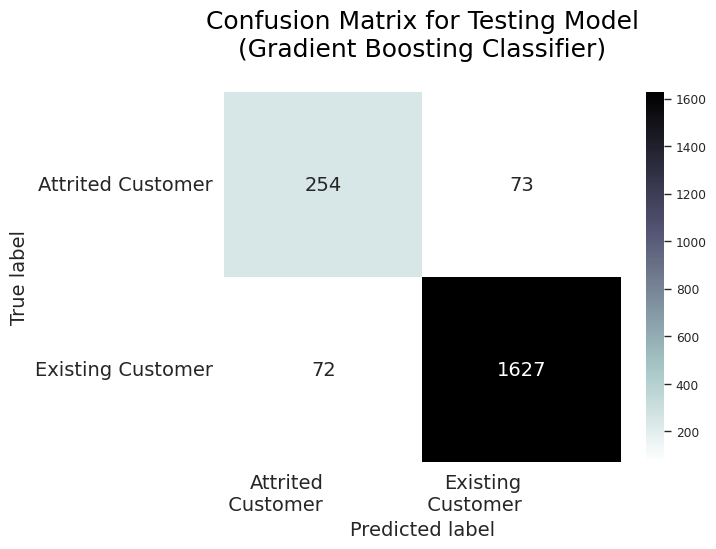

In [520]:
# form confusion matrix as a dataFrame
confusion_matrix_gbt = pd.DataFrame((confusion_matrix(y_test, y_test_pred_gbt)), ('Attrited Customer', 'Existing Customer'), ('Attrited\n Customer', 'Existing\n Customer'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_dt, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Gradient Boosting Classifier)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [521]:
acc_gbt_train=round(gbt_model.score(X_train,y_train)*100,2)
acc_gbt_test=round(gbt_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_gbt_train))
print("Test Accuracy: % {}".format(acc_gbt_test))

Training Accuracy: % 96.46
Test Accuracy: % 95.66


In [522]:
# ROC scores
roc_auc_gbt = round(roc_auc_score(y_test, y_test_pred_gbt),4)
print('ROC AUC:', roc_auc_gbt)

ROC AUC: 0.8877


**5. Random Forest**

In [523]:
# train the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
print(rf_model)

RandomForestClassifier(random_state=42)


In [524]:
# predict data train
y_train_pred_rf = rf_model.predict(X_train)

# print classification report
print('Classification Report Training Model (Decision Tree Classifier):')
print(classification_report(y_train, y_train_pred_rf))

Classification Report Training Model (Decision Tree Classifier):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1300
           1       1.00      1.00      1.00      6801

    accuracy                           1.00      8101
   macro avg       1.00      1.00      1.00      8101
weighted avg       1.00      1.00      1.00      8101



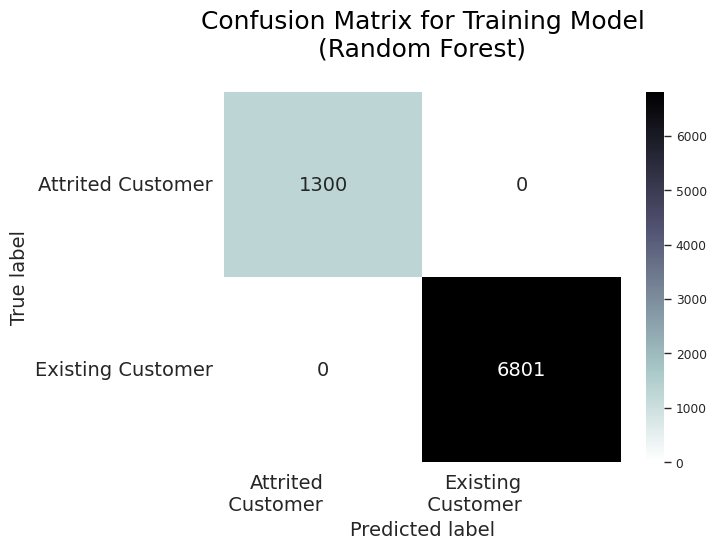

In [525]:
# form confusion matrix as a dataFrame
confusion_matrix_rf = pd.DataFrame((confusion_matrix(y_train, y_train_pred_rf)), ('Attrited Customer', 'Existing Customer'), ('Attrited\n Customer', 'Existing\n Customer'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_rf, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Random Forest)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [526]:
# predict data test
y_test_pred_rf = rf_model.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report

# print classification report
print('Classification Report Testing Model (Random Forest Classifier):')
print(classification_report(y_test, y_test_pred_rf))

Classification Report Testing Model (Random Forest Classifier):
              precision    recall  f1-score   support

           0       0.91      0.76      0.83       327
           1       0.95      0.99      0.97      1699

    accuracy                           0.95      2026
   macro avg       0.93      0.87      0.90      2026
weighted avg       0.95      0.95      0.95      2026



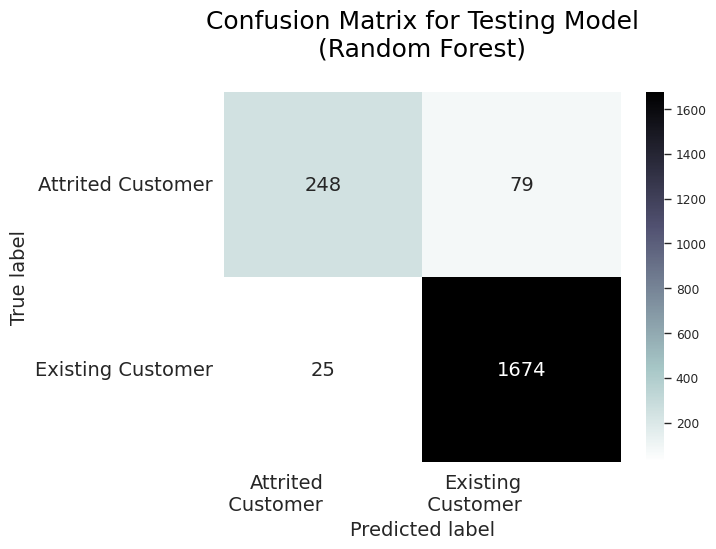

In [527]:
# form confusion matrix as a dataFrame
confusion_matrix_rf = pd.DataFrame((confusion_matrix(y_test, y_test_pred_rf)), ('Attrited Customer', 'Existing Customer'), ('Attrited\n Customer', 'Existing\n Customer'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_rf, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Random Forest)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [528]:
acc_rf_train=round(rf_model.score(X_train,y_train)*100,2)
acc_rf_test=round(rf_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_rf_train))
print("Test Accuracy: % {}".format(acc_rf_test))

Training Accuracy: % 100.0
Test Accuracy: % 94.87


In [529]:
# ROC scores
roc_auc_rf = round(roc_auc_score(y_test, y_test_pred_rf),4)
print('ROC AUC:', roc_auc_rf)

ROC AUC: 0.8718


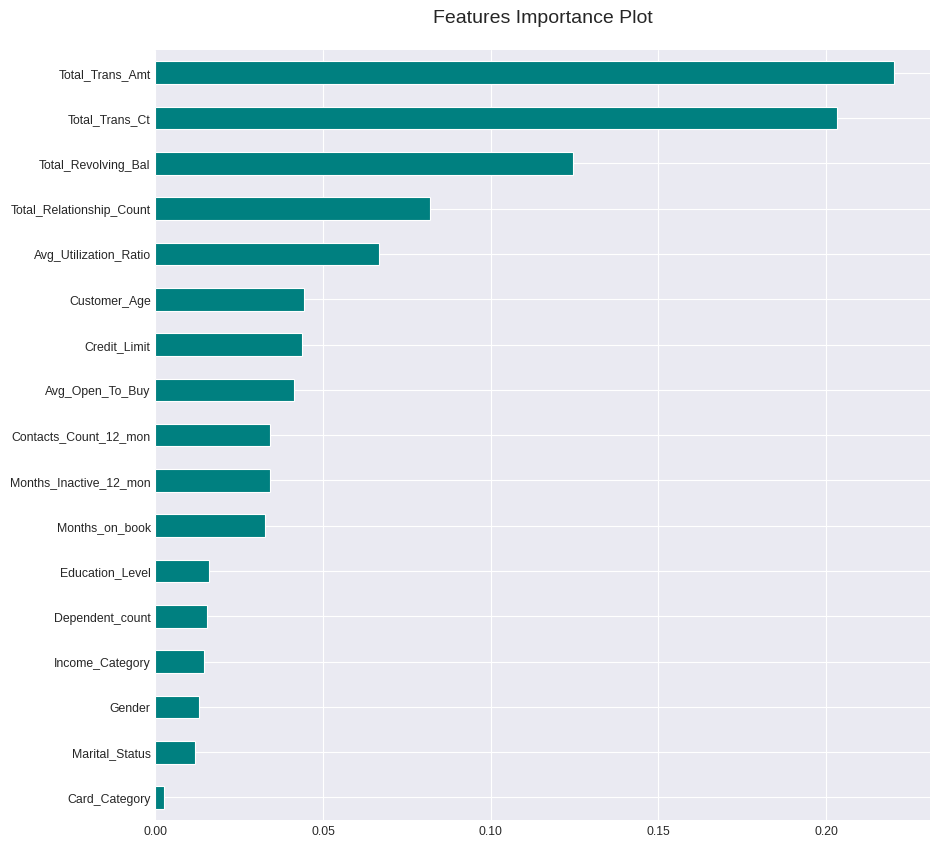

In [530]:
# important features
importances_rf = pd.Series(rf_model.feature_importances_, index=x.columns).sort_values(ascending=True)

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10,10))
fig = importances_rf.plot(kind ='barh', color ='teal')
plt.title('Features Importance Plot\n', fontsize=14)
plt.show()

fig.figure.tight_layout()
fig.figure.savefig('top feature.png')

# **Model Selection**

In [531]:
results = pd.DataFrame([["Logistic Regression", 0.8988, 0.886, 0.7258],["Gaussian Naive Bayes", 0.8747, 0.8653, 0.7721],
                       ["Decision Tree", 1, 0.9255, 0.8649],["Gradient Boosting Classifier",0.9646,0.9566,0.8877],["Random Forest", 1, 0.9487, 0.8718]],
                        columns = ["Models", "Training Accuracy Score", "Testing Accuracy Score", "ROC Score"]).reset_index(drop=True)

results.sort_values(by=['Training Accuracy Score', 'Testing Accuracy Score','ROC Score'], ascending=False).reset_index(drop=True).style.background_gradient(cmap='mako')

,Models,Training Accuracy Score,Testing Accuracy Score,ROC Score
0,Random Forest,1.000000,0.948700,0.871800
1,Decision Tree,1.000000,0.925500,0.864900
2,Gradient Boosting Classifier,0.964600,0.956600,0.887700
3,Logistic Regression,0.898800,0.886000,0.725800
4,Gaussian Naive Bayes,0.874700,0.865300,0.772100


- Of these metrics, the **Gradient Boosting Classifier** stands out with the highest Testing Accuracy Score (95.66%) and the highest ROC Score (88.77%).
- This shows that this model has the best performance in distinguishing between positive and negative classes and also has high accuracy on untrained data.
<br>

Thus, based on the data presented, the **Gradient Boosting Classifier** is the best model among the five models.

# **Prediction**

**Import Dataset**

In [532]:
df_test = df.copy()

In [533]:
print('The number of duplication is:', df_test.duplicated().sum())
# there is no duplication

The number of duplication is: 0


In [534]:
#drop unecessary column
df_test = df_test.drop(columns=['idstatus','Educationid','Maritalid','card_categoryid'])
df.head()

,CLIENTNUM,idstatus,status,Customer_Age,Gender,Dependent_count,Educationid,Education_Level,Maritalid,Marital_Status,Income_Category,card_categoryid,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Trans_Amt,Total_Trans_Ct,Avg_Utilization_Ratio
0,768805383,1,Existing Customer,45,Male,3,1,High School,1,Married,$60K - $80K,1,Blue,39,5,1,3,12691,777,11914,1144,42,0.061
1,818770008,1,Existing Customer,49,Female,5,2,Graduate,2,Single,Less than $40K,1,Blue,44,6,1,2,8256,864,7392,1291,33,0.105
2,713982108,1,Existing Customer,51,Male,3,2,Graduate,1,Married,$80K - $120K,1,Blue,36,4,1,0,3418,0,3418,1887,20,0.000
3,769911858,1,Existing Customer,40,Female,4,1,High School,3,Unknown,Less than $40K,1,Blue,34,3,4,1,3313,2517,796,1171,20,0.760
4,709106358,1,Existing Customer,40,Male,3,3,Uneducated,1,Married,$60K - $80K,1,Blue,21,5,1,0,4716,0,4716,816,28,0.000


In [535]:
# check for empty elements
print('Missing values status:', df_test.isnull().values.any())
df_null = pd.DataFrame(df_test.isnull().sum(), columns=['Total Null Values'])
df_null['Percentage'] = (df_null['Total Null Values']/df_test.shape[0])*100
df_null = df_null.sort_values(by=['Percentage'], ascending=False).reset_index()
df_null

Missing values status: False


,index,Total Null Values,Percentage
0,CLIENTNUM,0,0.0
1,Total_Relationship_Count,0,0.0
2,Total_Trans_Ct,0,0.0
3,Total_Trans_Amt,0,0.0
4,Avg_Open_To_Buy,0,0.0
5,Total_Revolving_Bal,0,0.0
6,Credit_Limit,0,0.0
7,Contacts_Count_12_mon,0,0.0
8,Months_Inactive_12_mon,0,0.0
9,Months_on_book,0,0.0


In [536]:
df_test.head()

,CLIENTNUM,status,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Trans_Amt,Total_Trans_Ct,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,Male,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691,777,11914,1144,42,0.061
1,818770008,Existing Customer,49,Female,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256,864,7392,1291,33,0.105
2,713982108,Existing Customer,51,Male,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418,0,3418,1887,20,0.000
3,769911858,Existing Customer,40,Female,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313,2517,796,1171,20,0.760
4,709106358,Existing Customer,40,Male,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716,0,4716,816,28,0.000


In [537]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   status                    10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  int64  
 14  Total_

In [538]:
#Encoding Features
cleaned_df_test = df_test.drop(['CLIENTNUM'], axis=1)

from sklearn.preprocessing import LabelEncoder
#Convert all the non-numeric columns to numerical data types
for column in cleaned_df_test.columns:
    if cleaned_df_test[column].dtype == np.number: continue
    # Perform encoding for each non-numeric column
    cleaned_df_test[column] = LabelEncoder().fit_transform(cleaned_df_test[column])
print(cleaned_df_test.describe())

             status  Customer_Age        Gender  Dependent_count  \
count  10127.000000  10127.000000  10127.000000     10127.000000   
mean       0.839340     20.325565      0.470919         2.346203   
std        0.367235      8.015598      0.499178         1.298908   
min        0.000000      0.000000      0.000000         0.000000   
25%        1.000000     15.000000      0.000000         1.000000   
50%        1.000000     20.000000      0.000000         2.000000   
75%        1.000000     26.000000      1.000000         3.000000   
max        1.000000     44.000000      1.000000         5.000000   

       Education_Level  Marital_Status  Income_Category  Card_Category  \
count     10127.000000    10127.000000     10127.000000   10127.000000   
mean          3.096574        1.463415         2.863928       0.179816   
std           1.834812        0.737808         1.504700       0.693039   
min           0.000000        0.000000         0.000000       0.000000   
25%           2.0

# **Prediction**

In [539]:
pred_test = cleaned_df_test.drop(['status'], axis=1)

In [540]:
# lets predict!
predict = pd.Series(gbt_model.predict(pred_test), name = 'status').astype(int)
results = pd.concat([df_test['CLIENTNUM'], predict],axis = 1)
results.rename(columns = {'status':'status_pred'}, inplace = True)
results.sort_values(by='status_pred',ascending=True).reset_index(drop=True).head()

,CLIENTNUM,status_pred
0,768805383,0
1,714058308,0
2,718054833,0
3,712450008,0
4,711341433,0


In [541]:
results_summary = results.groupby('status_pred').agg(customer_cnt=('CLIENTNUM','count')).reset_index()
results_summary['Status_Meaning'] = ['Attrited Customer','Existing Customer']
results_summary = results_summary[['status_pred','Status_Meaning','customer_cnt']]
print('Churn Customer after predicted :')
results_summary

Churn Customer after predicted :


,status_pred,Status_Meaning,customer_cnt
0,0,Attrited Customer,4920
1,1,Existing Customer,5207


In [542]:
df = results.copy()

def status_meaning(data):
  if data == 0:
    return 'Attrited Customer'
  elif data == 1:
    return 'Existing Customer'

df['status_meaning'] = df['status_pred'].apply(status_meaning)

[Text(0, 0, '4920 (48.58%)'), Text(0, 0, '5207 (51.42%)')]

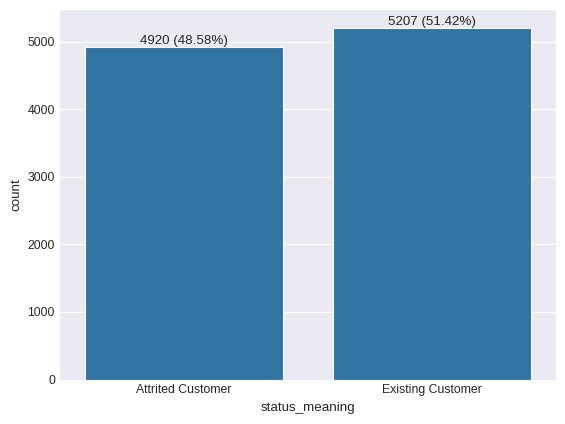

In [543]:
ax = sns.countplot(x=df['status_meaning'],
                   order=df['status_meaning'].value_counts(ascending=True).index);

abs_values = df['status_meaning'].value_counts(ascending=True)
rel_values = df['status_meaning'].value_counts(ascending=True, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.2f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)